In [1]:
# Assignment 5
# Relationship between solar radio flux F10.7 and sunspot number
# Team 2:
#     Ekaterina Karmanova
#     Timur Chikichev
#     Yaroslav Okunev
#     Nikita Mikhailovskiy
#
# Skoltech, 08.10.2019

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

In [3]:
#Constants
#Size of trajectory
c = 200
t=1
#Variance of acceleration noise
sa = 0.2
s2a = sa**2

#acceleration
a = np.random.normal(0,sa,c)
#Measurements
sn = 20
s2n = sn**2
n = np.random.normal(0,sn,c)

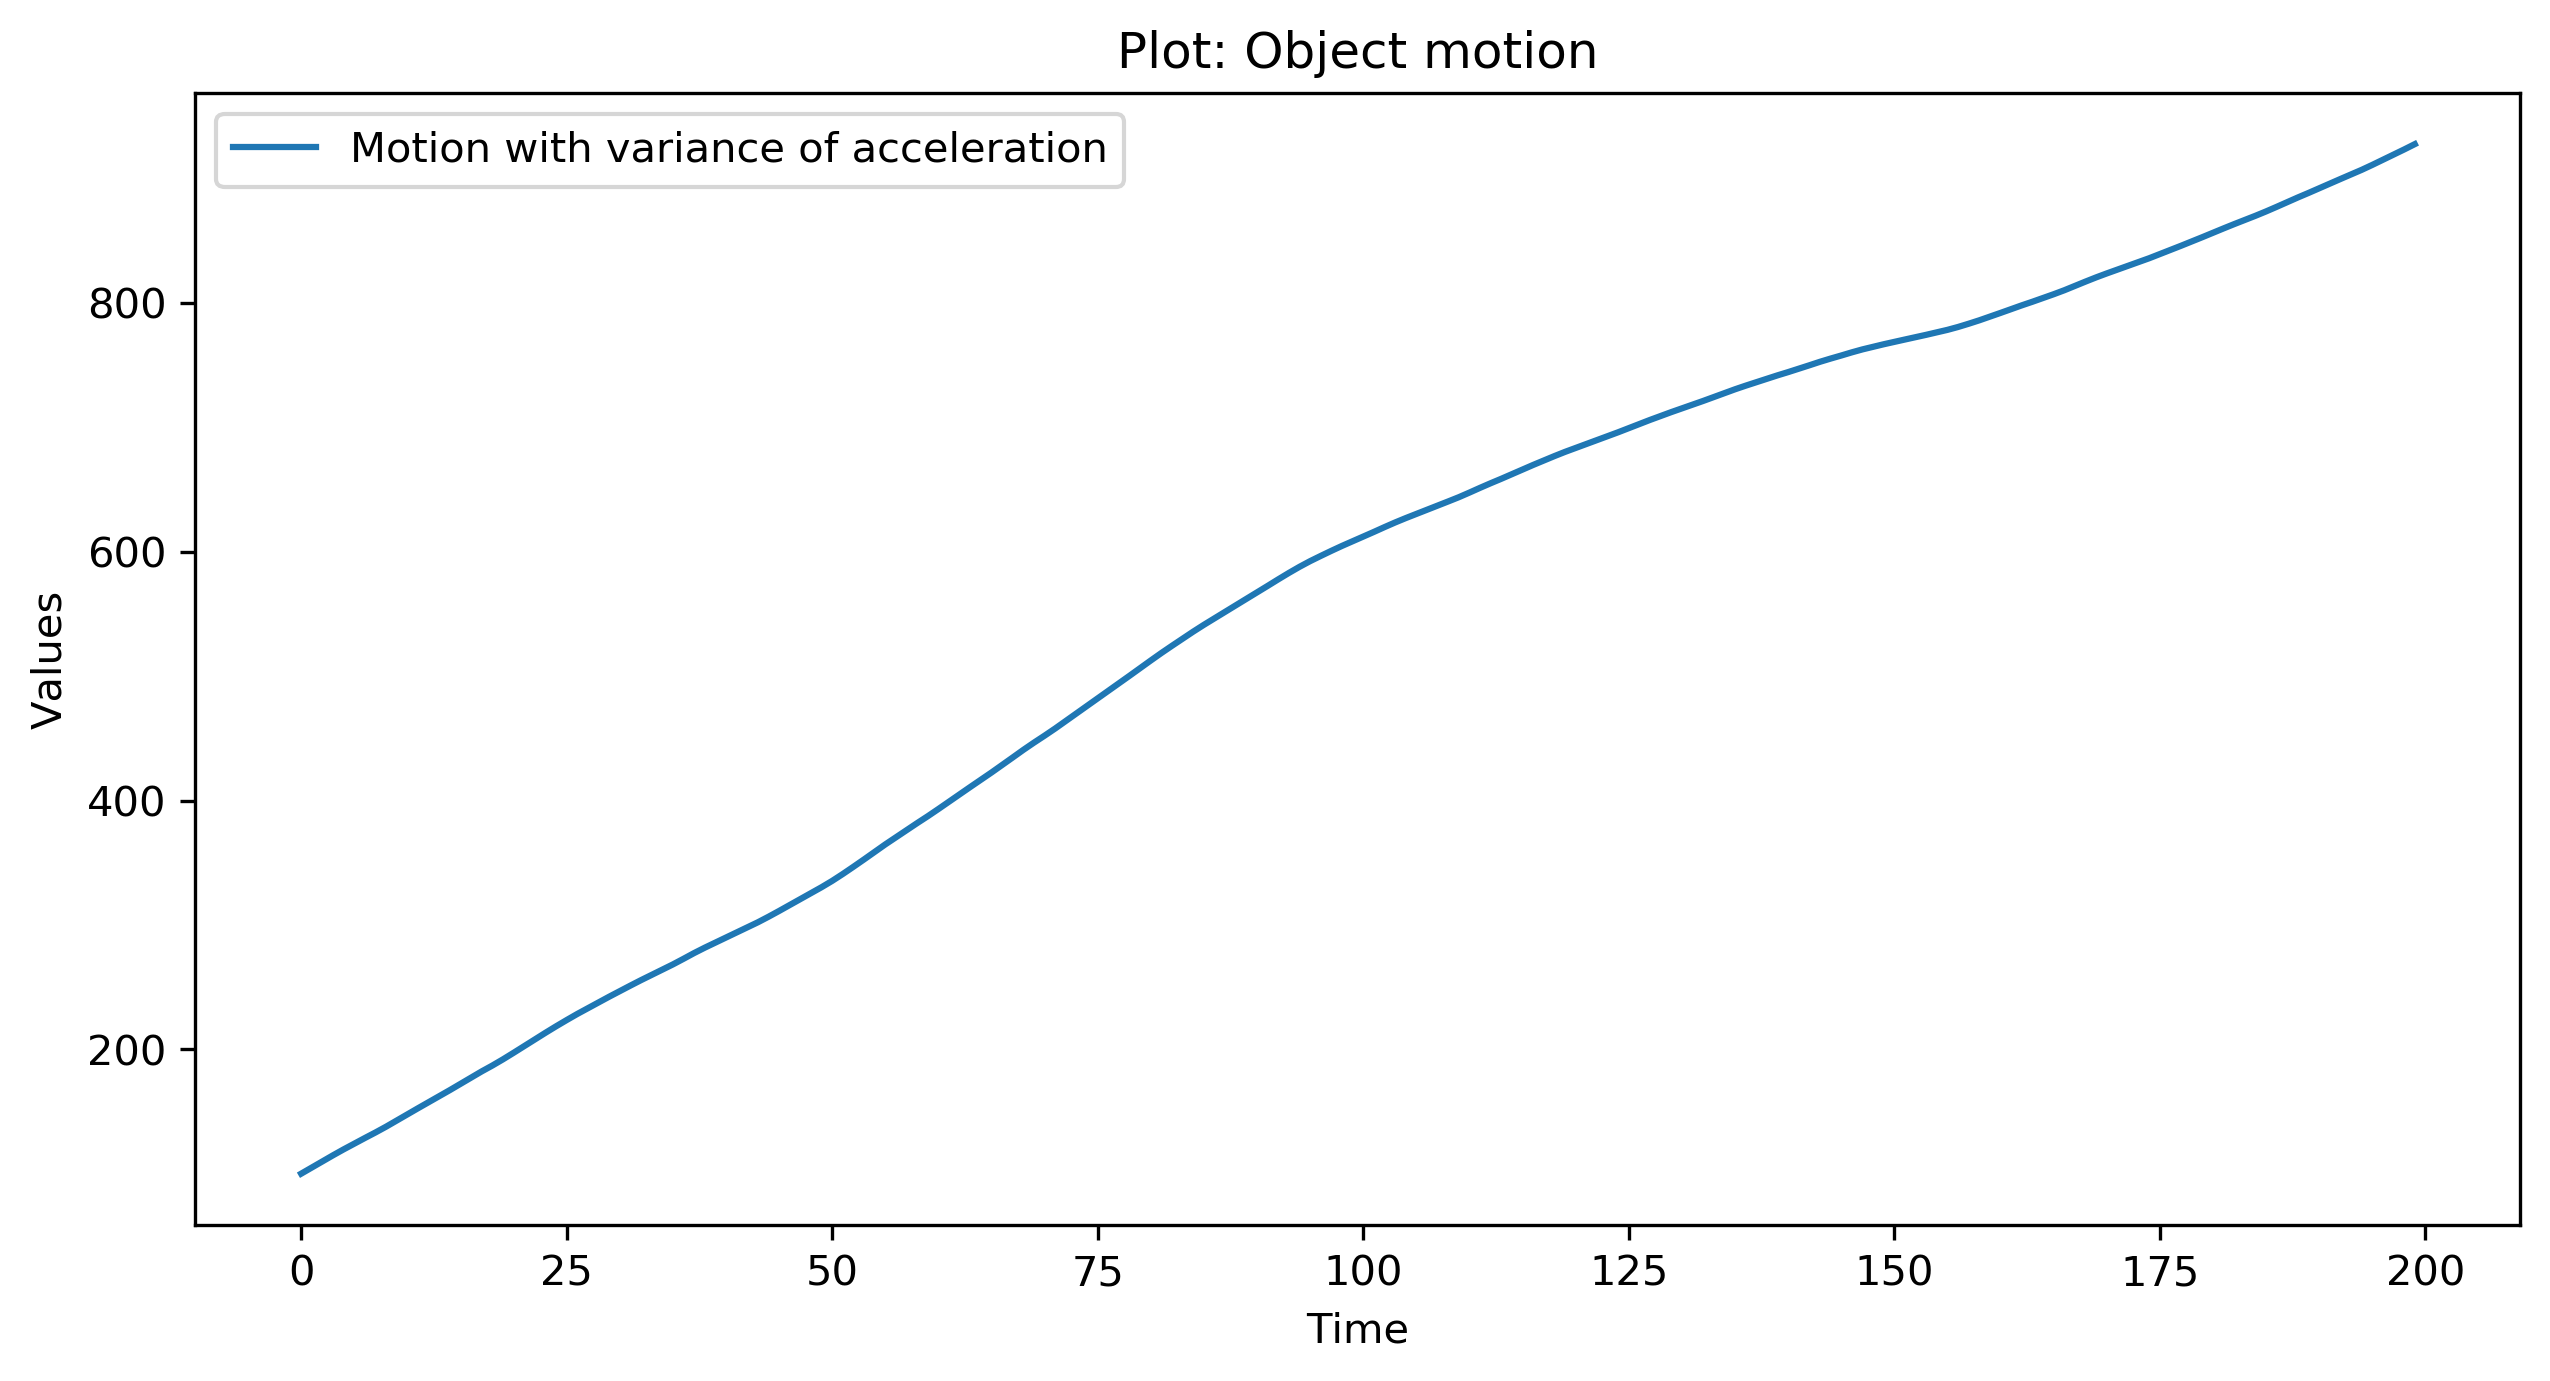

In [4]:
#3 Presenting state equation
X1 = np.matrix((100,5))
F = np.matrix(((1,t),(0,1)))
G = np.matrix((t**2/2,t)).T
H = np.matrix((1,0))

X = np.zeros([c,2])
X[0] = X1
for i in range (1,c):
    frst = np.matmul(F,np.asmatrix(X[i-1]).T)
    scnd = G.dot(a[i-1])
    X[i] = np.add(frst,scnd).T  
    
figure(num=None, figsize=(10, 5), dpi=300, facecolor='w', edgecolor='k')
plt.title('Plot: Object motion')    
plt.plot(X.T[0], label='Motion with variance of acceleration')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

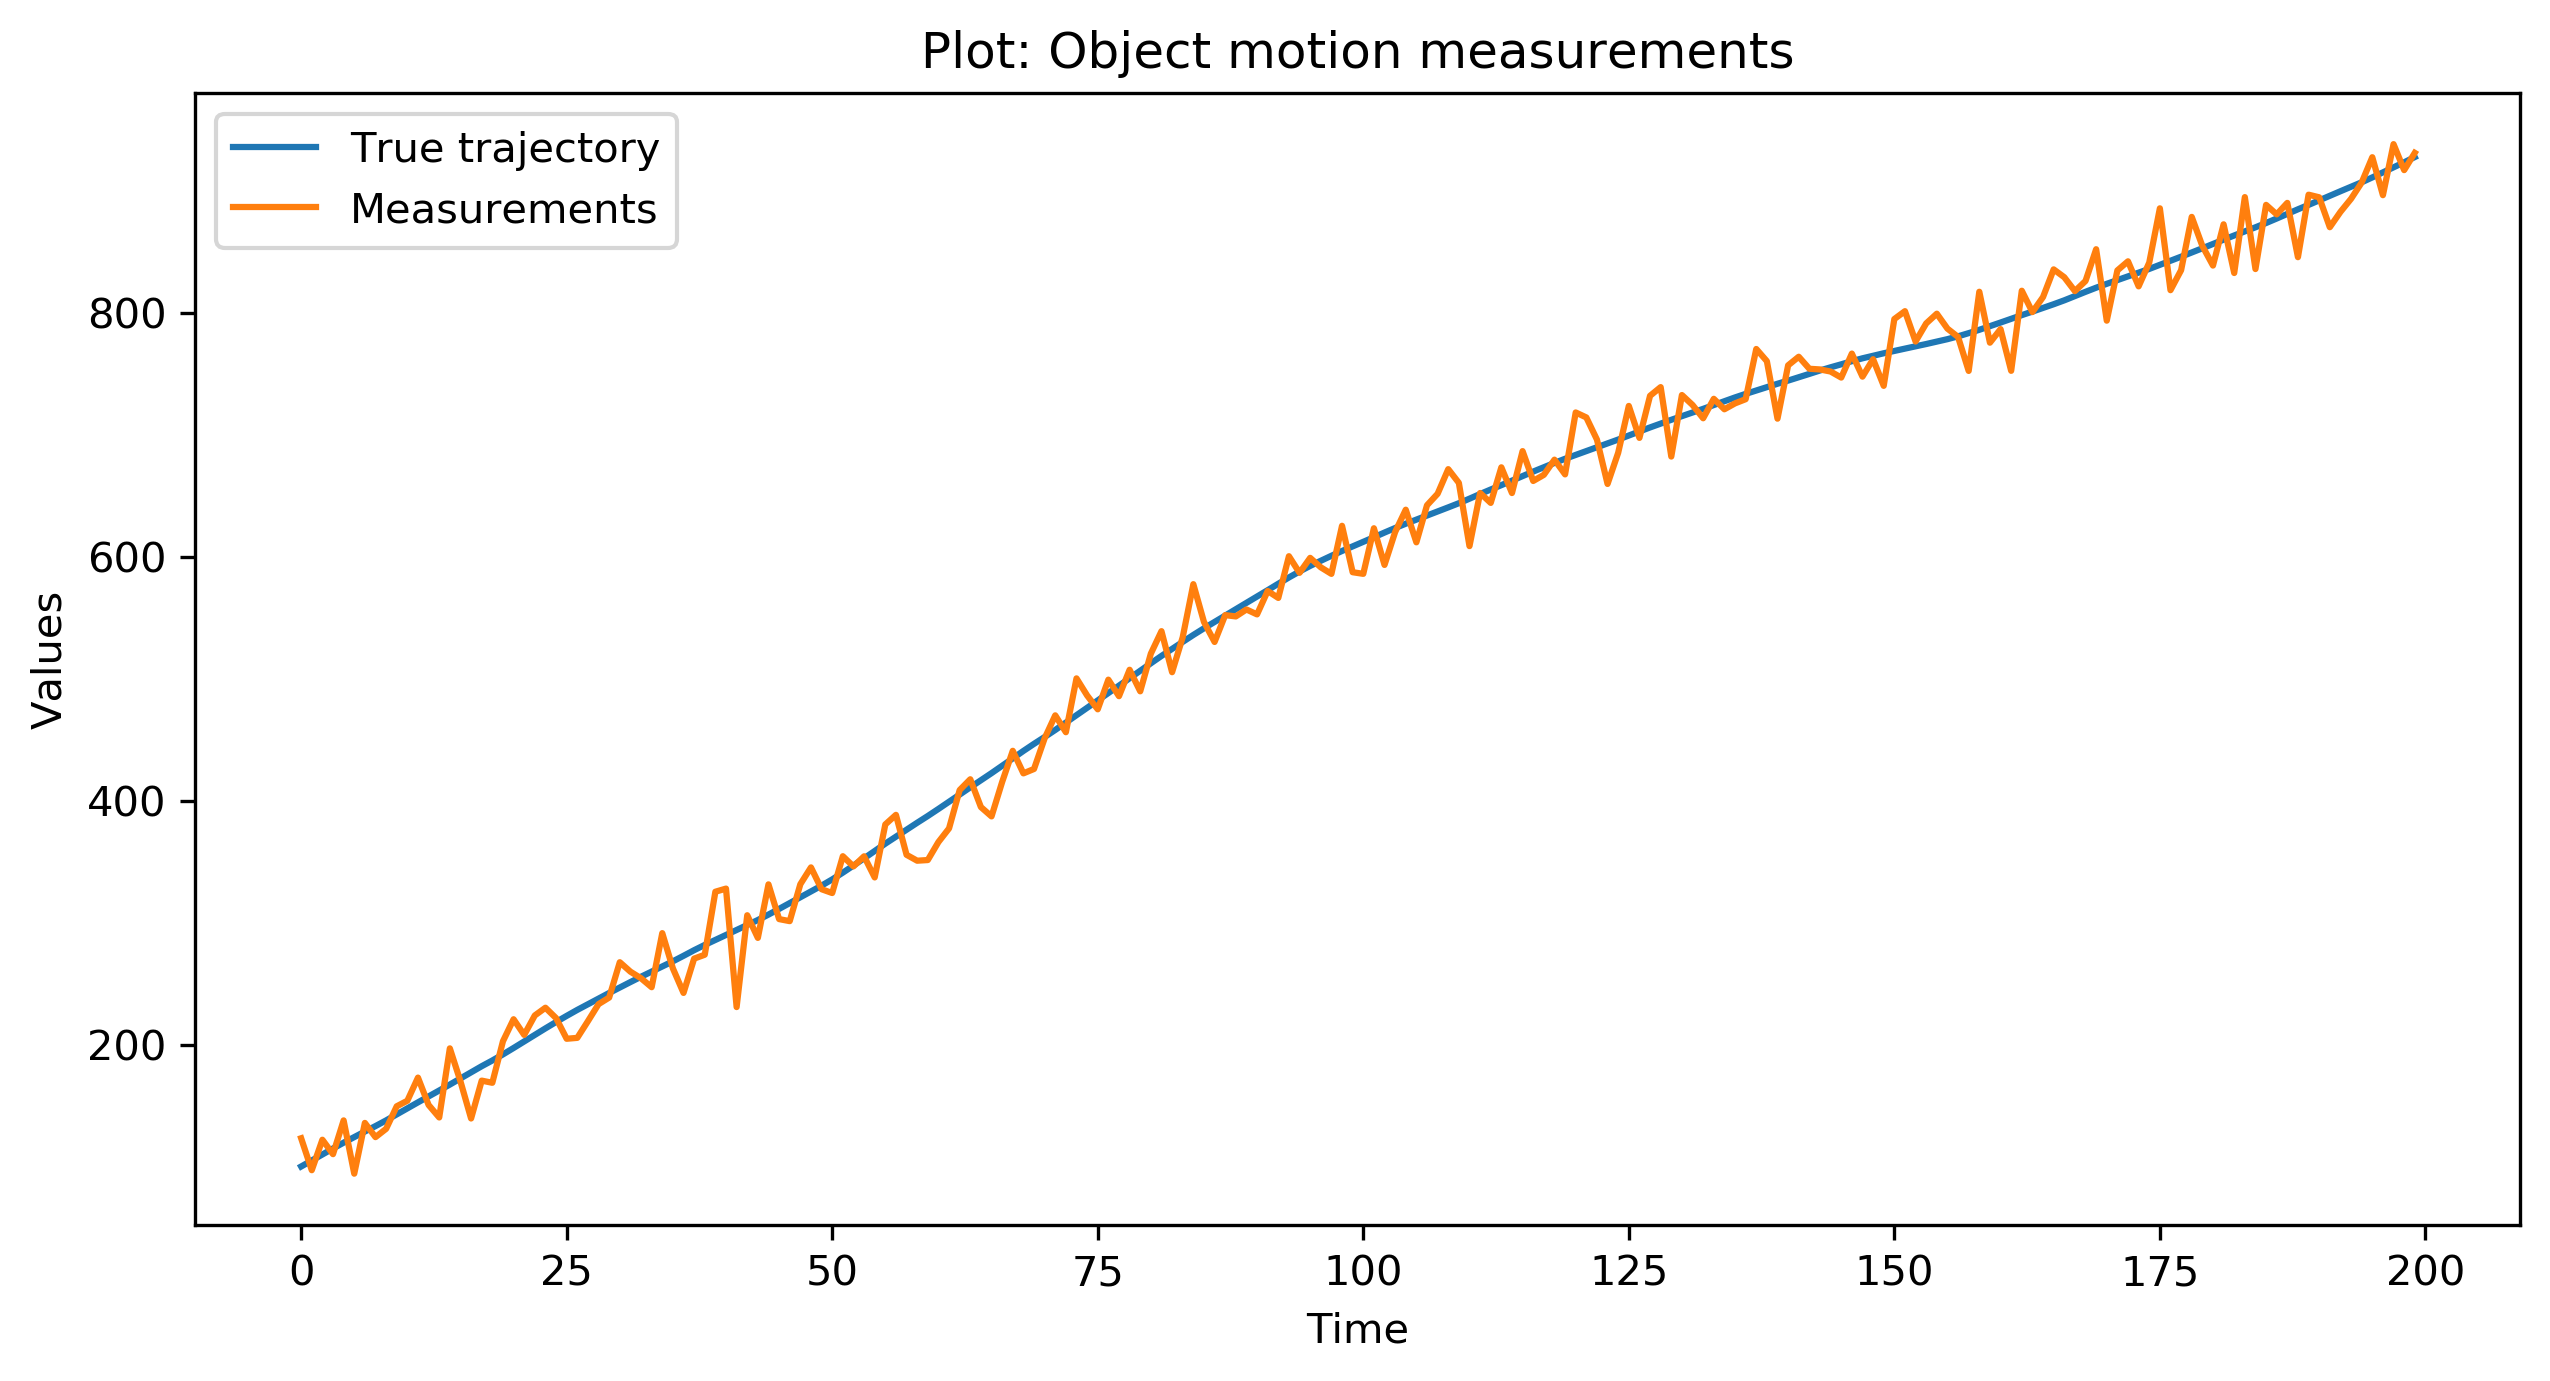

In [5]:
Z = np.zeros(c)
for i in range (c):
    Z[i] = H.dot(X[i])+n[i]
    
figure(num=None, figsize=(10, 5), dpi=300, facecolor='w', edgecolor='k')
plt.title('Plot: Object motion measurements')    
plt.plot(X.T[0], label='True trajectory')
plt.plot(Z, label='Measurements')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show() 

In [6]:
#4 Developing Kalman Filter
X0 = np.matrix((2,0))
P00 = np.matrix(((10000,0),(0,10000)))

#Covariance matrix Q
Q = np.matmul(G,G.T)*s2a
R = s2n
I = np.matrix(((1,0),(0,1)))

#Kalman filtering
def kalman(x):
    P = P00
    X_f = np.zeros([c,2])
    K_f = np.zeros([c,2])
    P_g = np.zeros(c)
    X_f[0] = X0
    for i in range (1,c):
        X_p = F.dot(np.asmatrix(X_f[i-1]).T)
        Pz = np.add(F.dot(P).dot(F.T),Q)
        frst = np.add(H.dot(Pz).dot(H.T),R)
        K = Pz.dot(H.T).dot(np.linalg.inv(frst))
        pre_scnd = np.subtract(x[i],H.dot(X_p))
        scnd = K.dot(pre_scnd)
        P = np.matmul(np.subtract(I,np.matmul(K,H)),Pz)
        X_f[i] = np.add(X_p,scnd).T
        K_f[i] = K.T
        P_g[i] = np.sqrt(P[0,0])
    #deleting first row
    K_f = np.delete(K_f, 0, 0)
    P_g = np.delete(P_g, 0, 0)
    return X_f.T, K_f.T[0], P_g
f, k, p = kalman(Z)

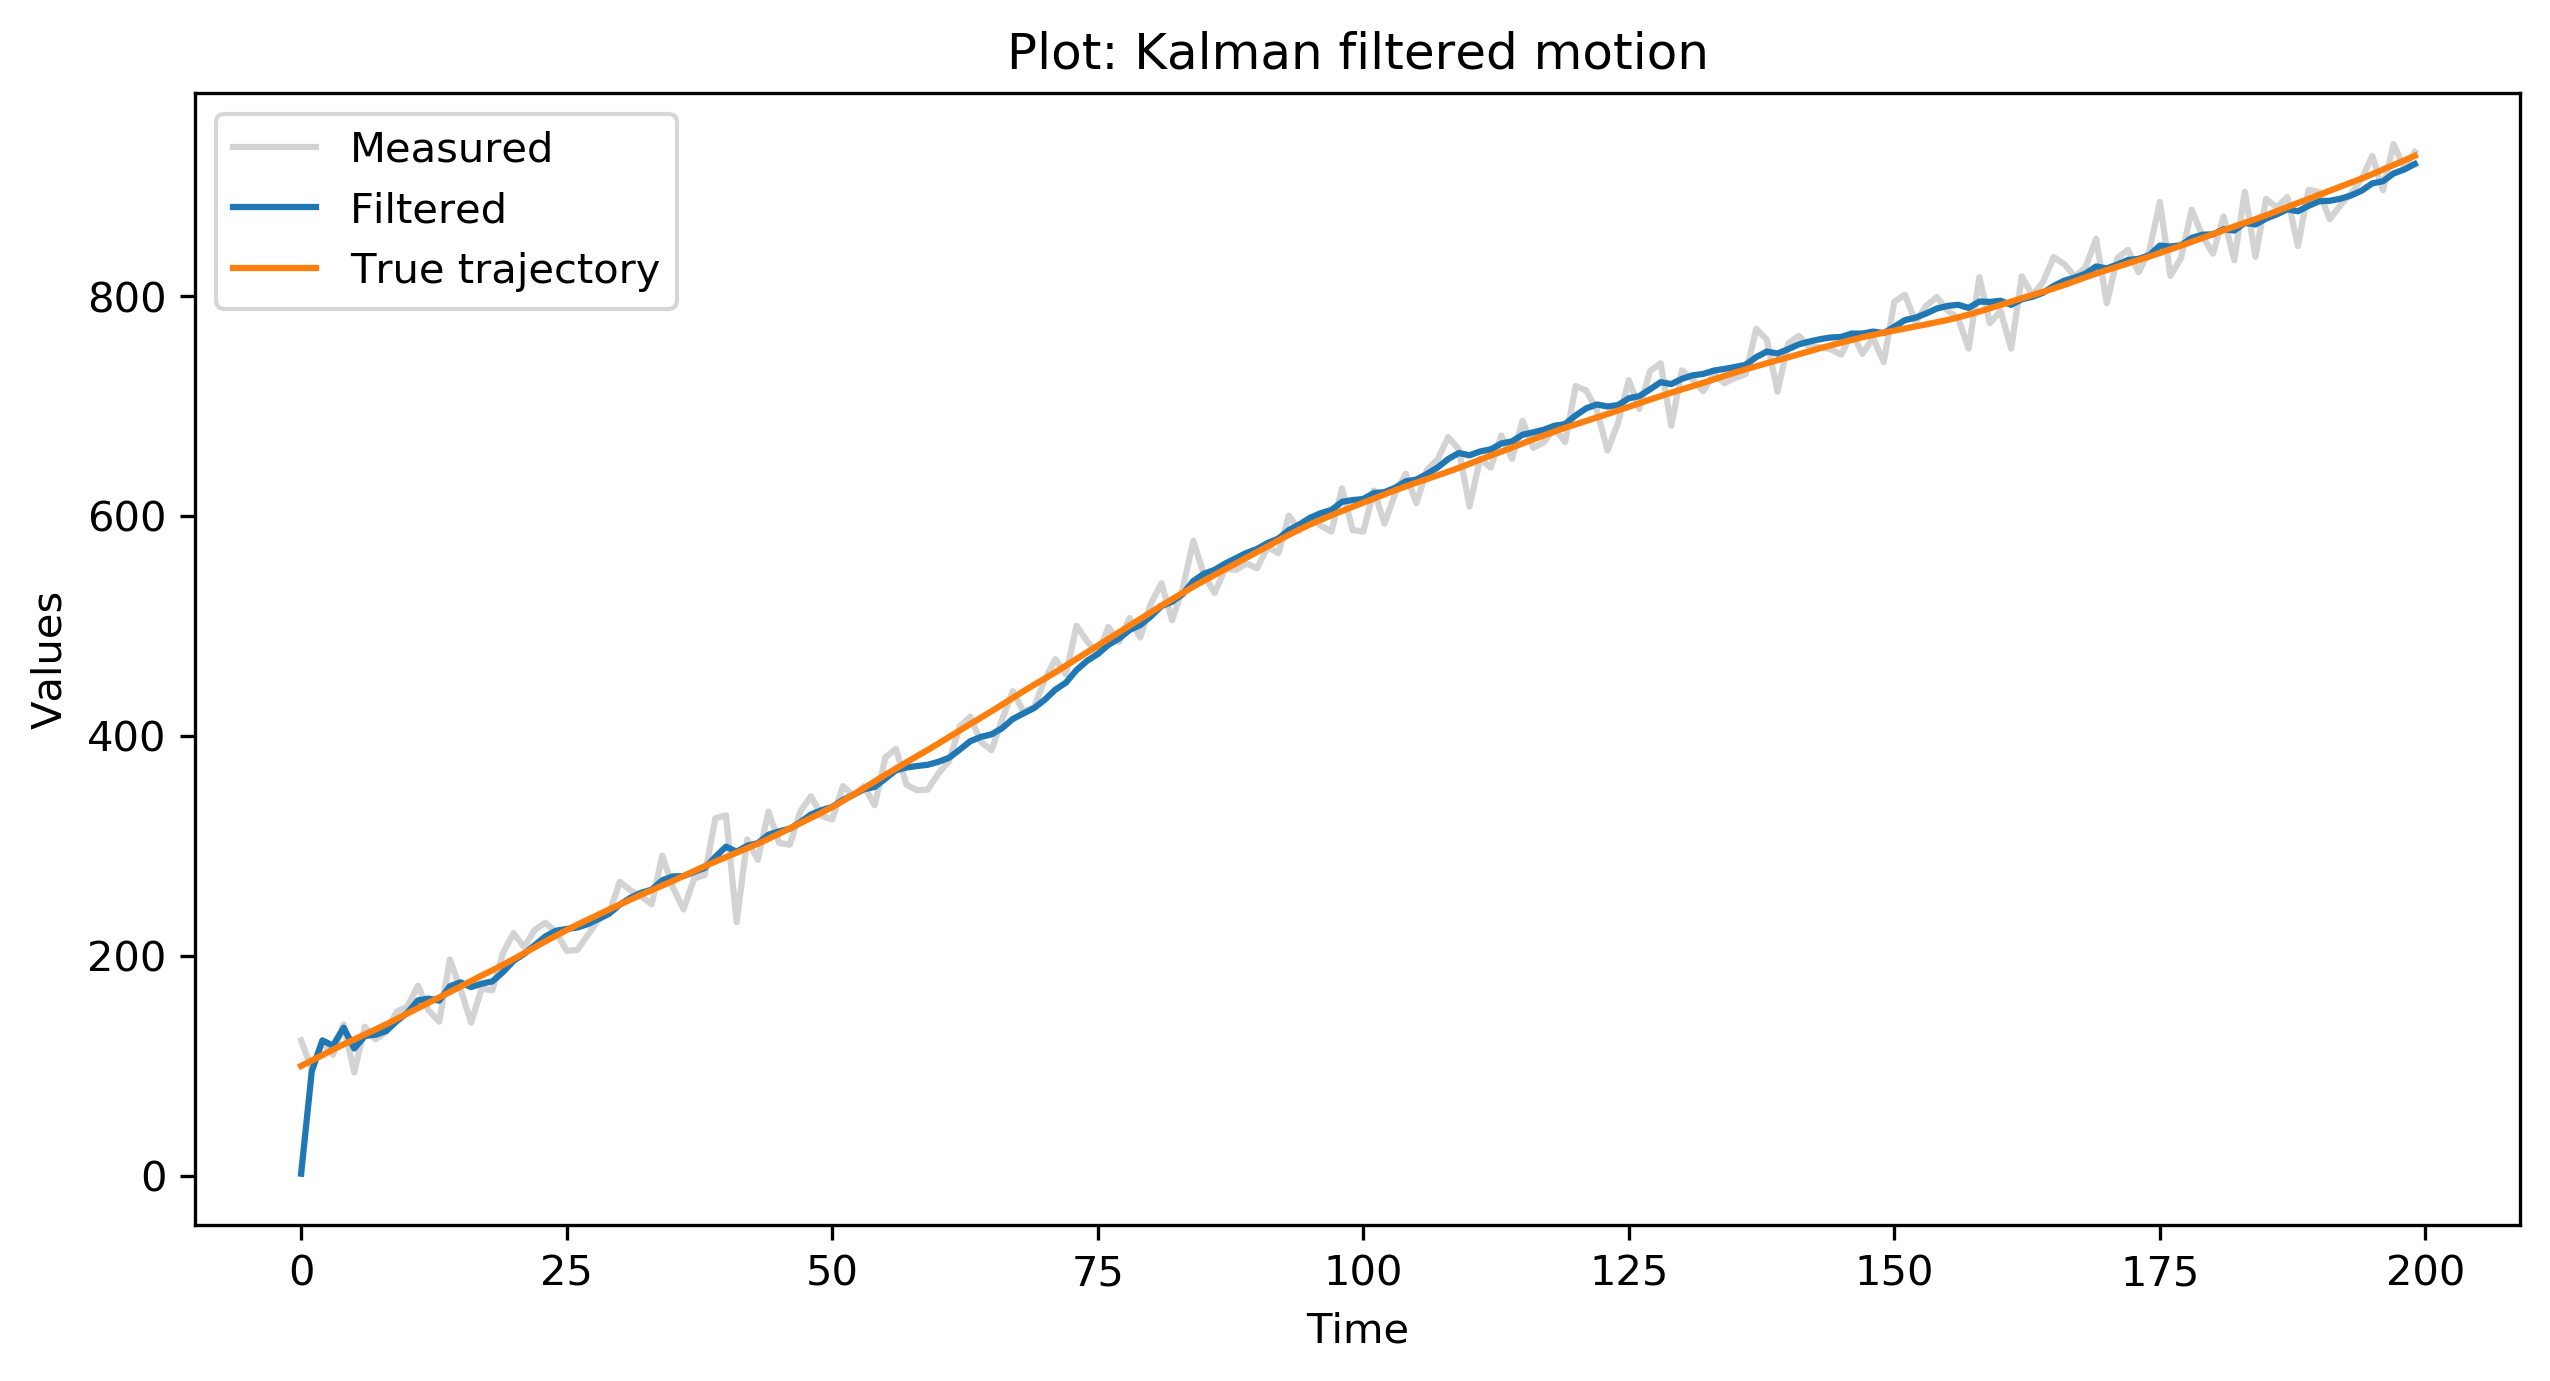

In [7]:
#Plotting the result
figure(num=None, figsize=(10, 5), dpi=300, facecolor='w', edgecolor='k')
plt.title('Plot: Kalman filtered motion')
plt.plot(Z, label='Measured', c='lightgrey')
plt.plot(f[0], label='Filtered')
plt.plot(X.T[0], label='True trajectory')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

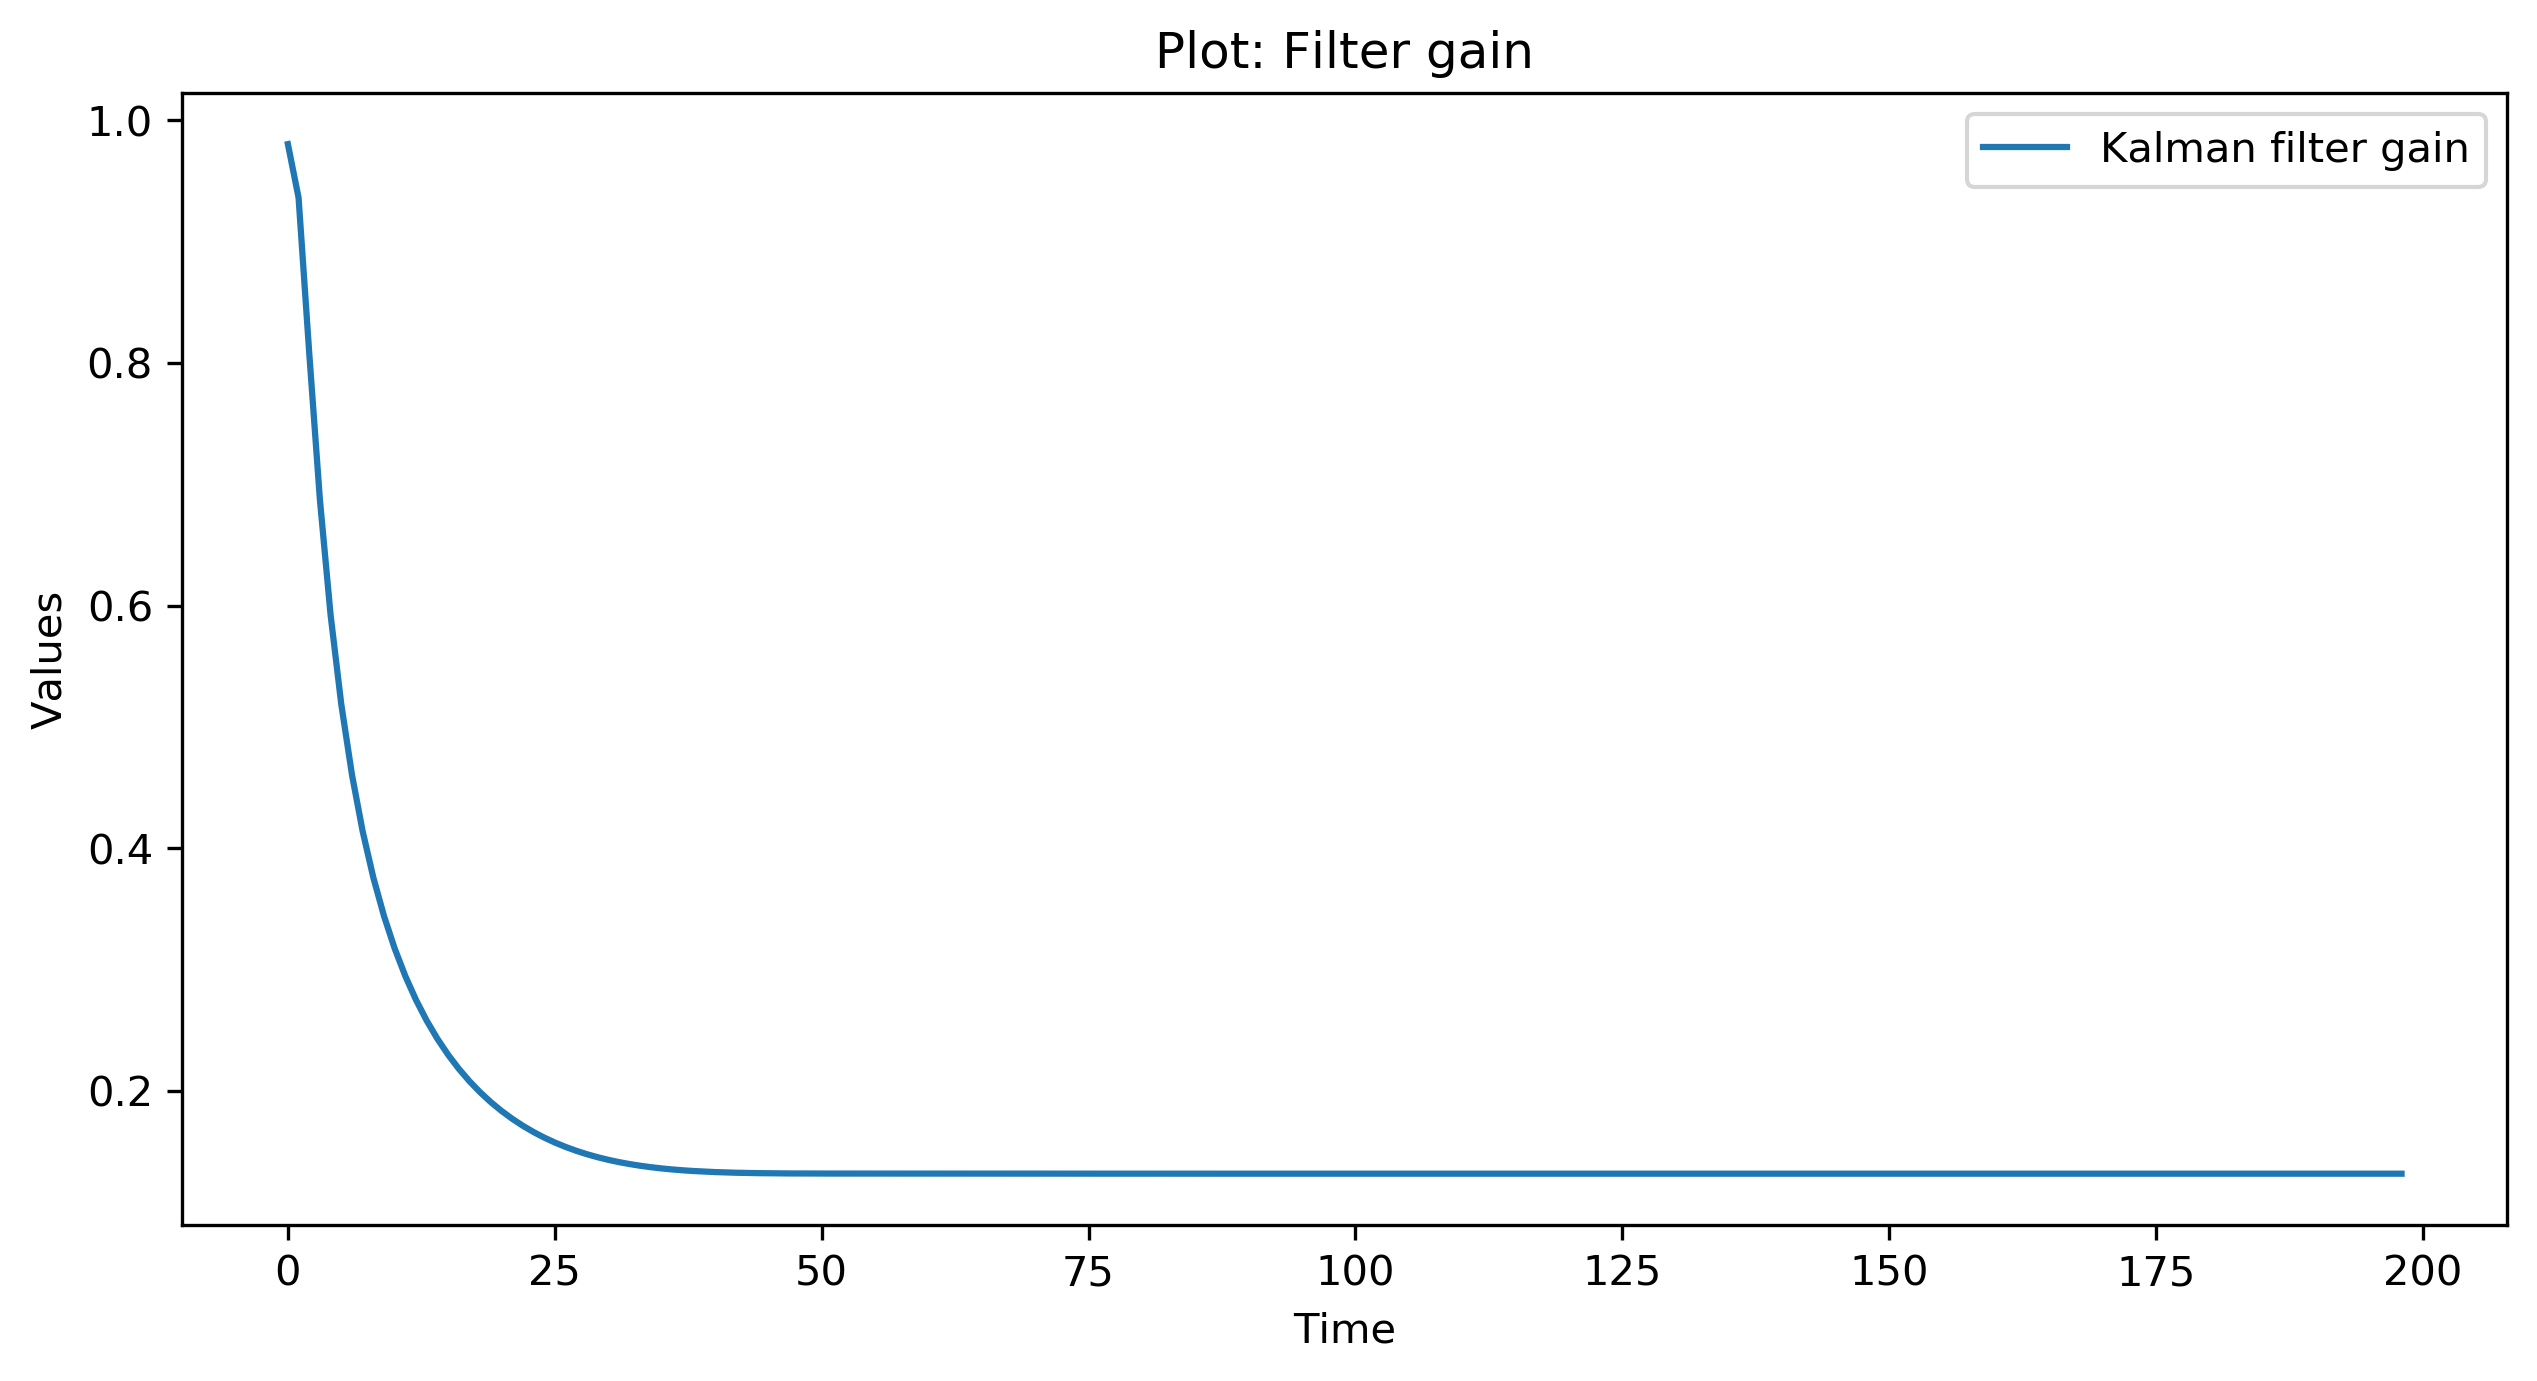

0.13185099157078947

In [8]:
#Plot filter gain K
figure(num=None, figsize=(10, 5), dpi=300, facecolor='w', edgecolor='k')
plt.title('Plot: Filter gain')    
plt.plot(k, label='Kalman filter gain')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()
k[150]

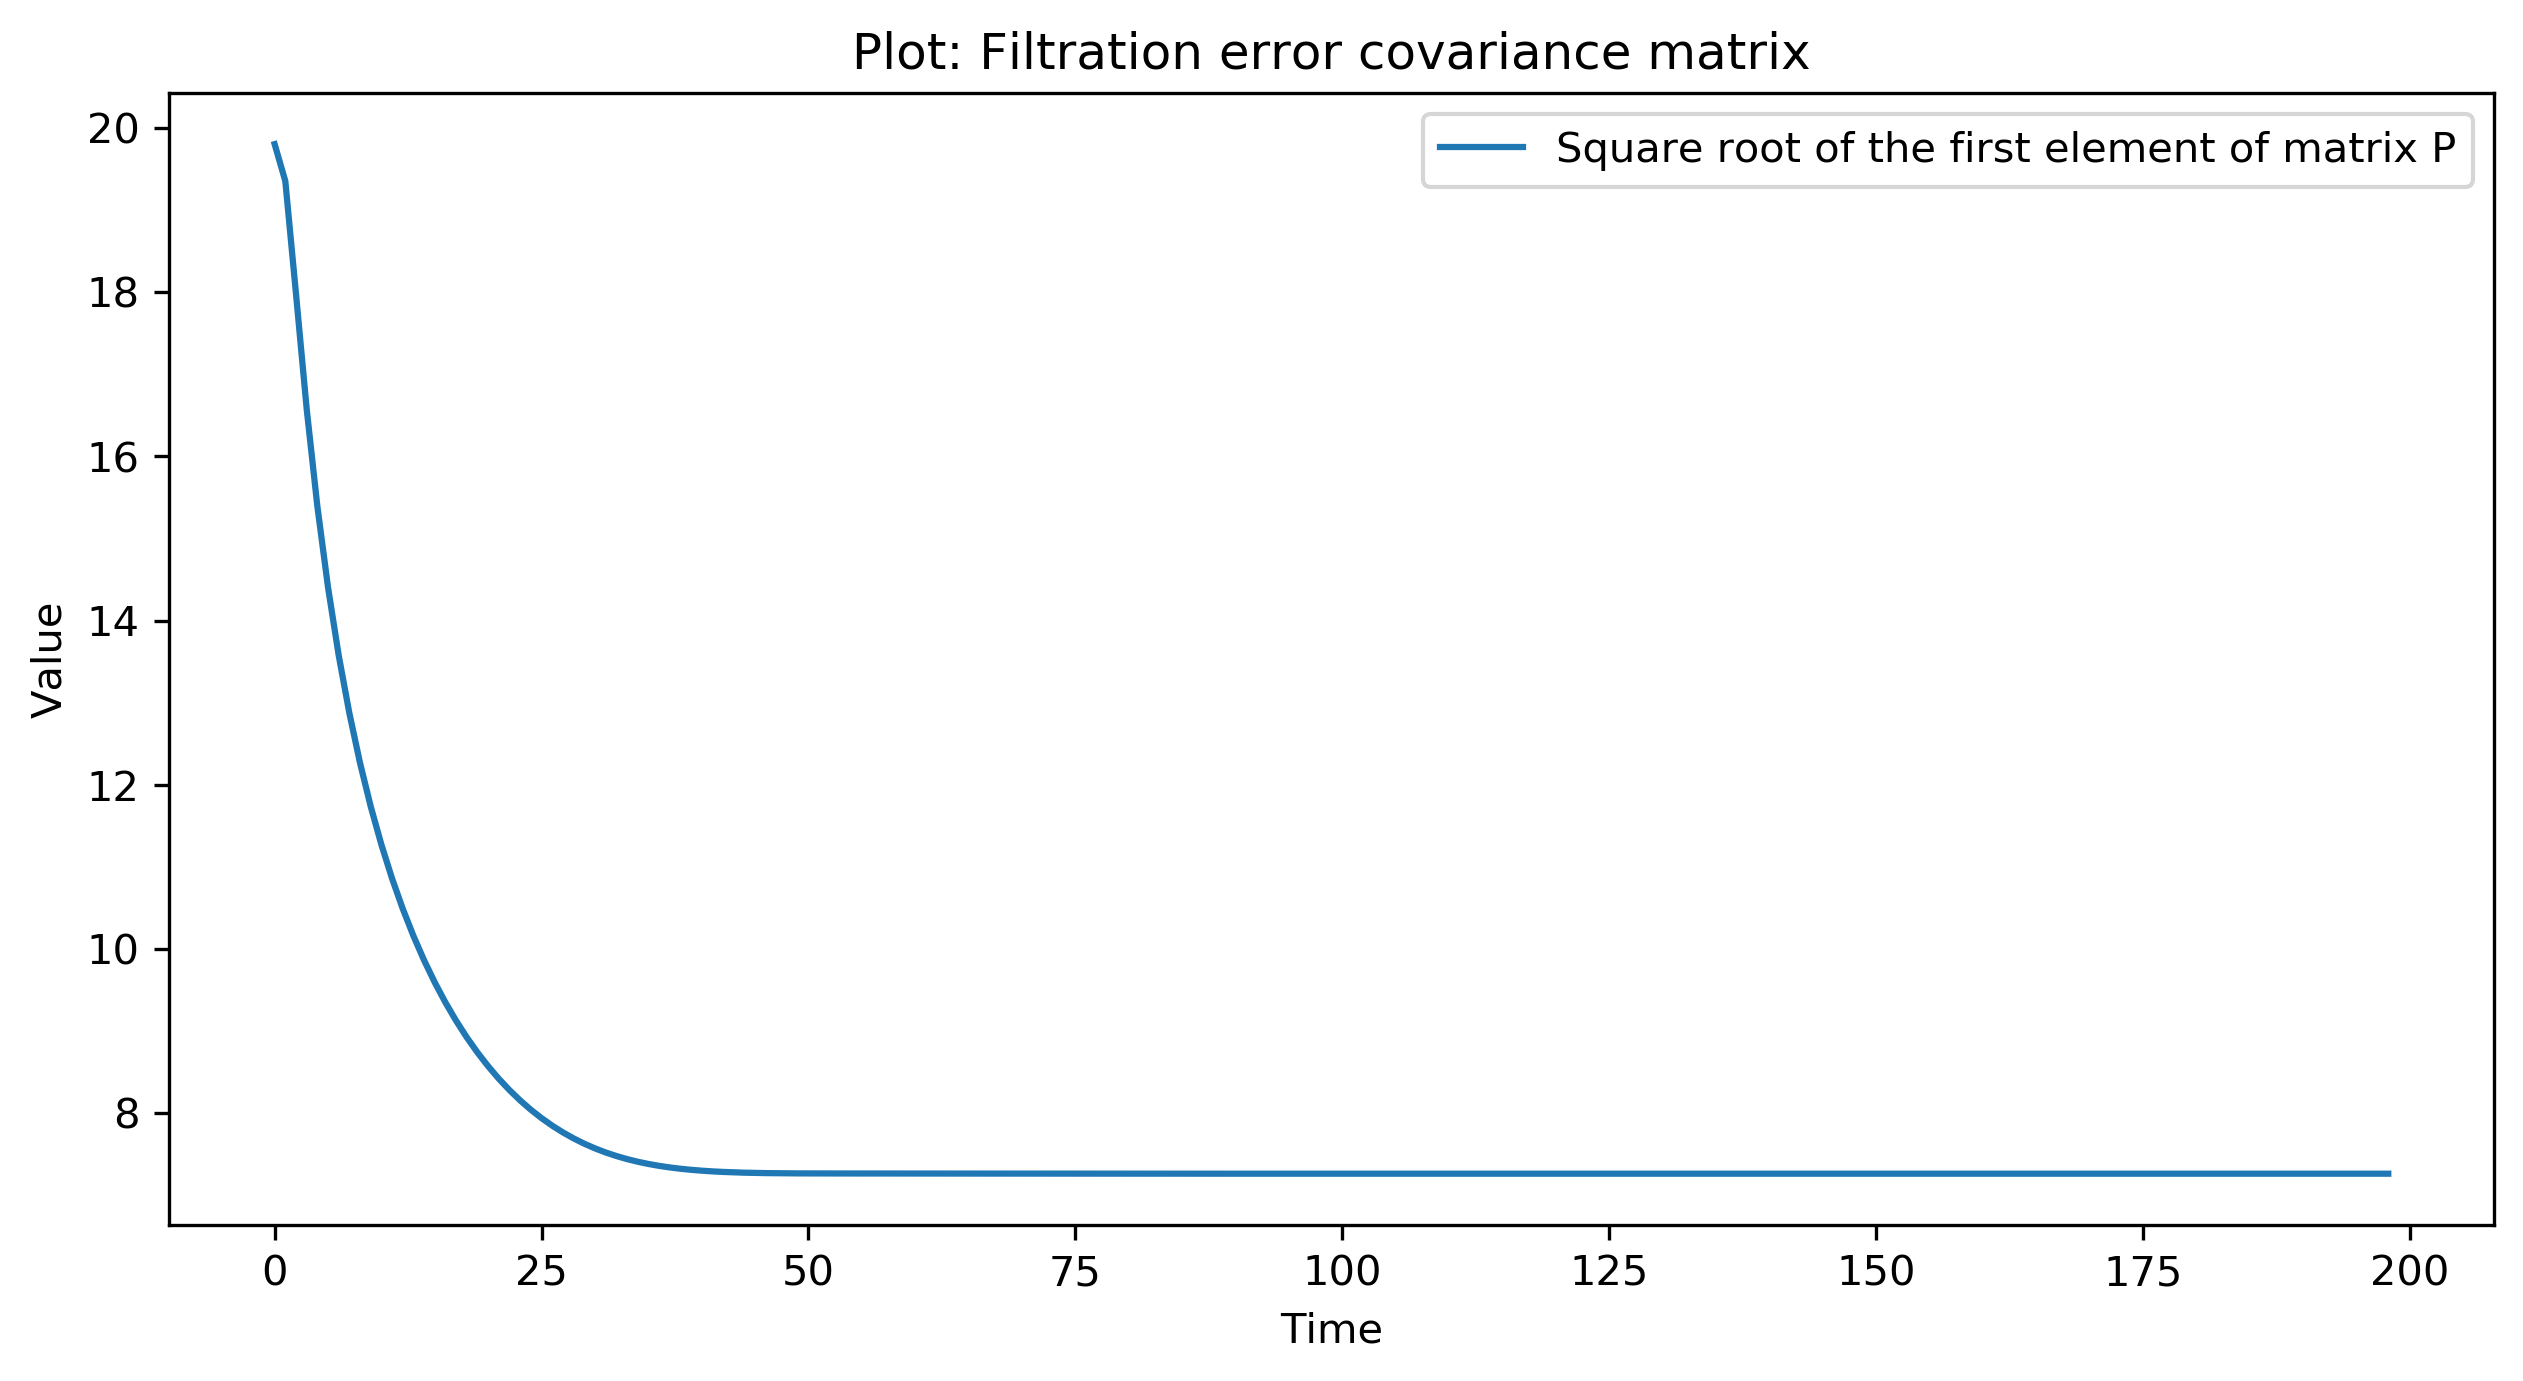

In [9]:
#P
figure(num=None, figsize=(10, 5), dpi=300, facecolor='w', edgecolor='k')
plt.title('Plot: Filtration error covariance matrix')    
plt.plot(p, label='Square root of the first element of matrix P')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [10]:
def run(n):
    def gen():
        a = np.random.normal(0,sa,c)
        n = np.random.normal(0,sn,c)
        X1 = np.matrix((5,1))
        F = np.matrix(((1,t),(0,1)))
        G = np.matrix((t**2/2,t)).T
        H = np.matrix((1,0))

        X = np.zeros([c,2])
        X[0] = X1
        for i in range (1,c):
            frst = np.matmul(F,np.asmatrix(X[i-1]).T)
            scnd = G.dot(a[i-1])
            X[i] = np.add(frst,scnd).T
        Z = np.zeros(c)
        for i in range (c):
            Z[i] = H.dot(X[i])+n[i]
        return X.T,Z
        
    def kalman(z_g):
        P = P00
        X_f = np.zeros([c,2])
        X_f[0] = X0
        for i in range (1,c):
            X_p = F.dot(np.asmatrix(X_f[i-1]).T)
            Pz = np.add(F.dot(P).dot(F.T),Q)
            frst = np.add(H.dot(Pz).dot(H.T),R)
            K = Pz.dot(H.T).dot(np.linalg.inv(frst))
            pre_scnd = np.subtract(z_g[i],H.dot(X_p))
            scnd = K.dot(pre_scnd)
            P = np.matmul(np.subtract(I,np.matmul(K,H)),Pz)
            X_f[i] = np.add(X_p,scnd).T
        return X_f.T

    error = np.zeros(c)
    for i in range (n):
        cur_x,cur_z = gen()
        res = kalman(cur_z)
        s = np.power(np.subtract(cur_x[0],res[0]),2)
        error = np.add(s,error)
    final = np.zeros(c)
    for k in range (2,c):
        final[k] = np.sqrt(error[k]/(n-1))
    return final

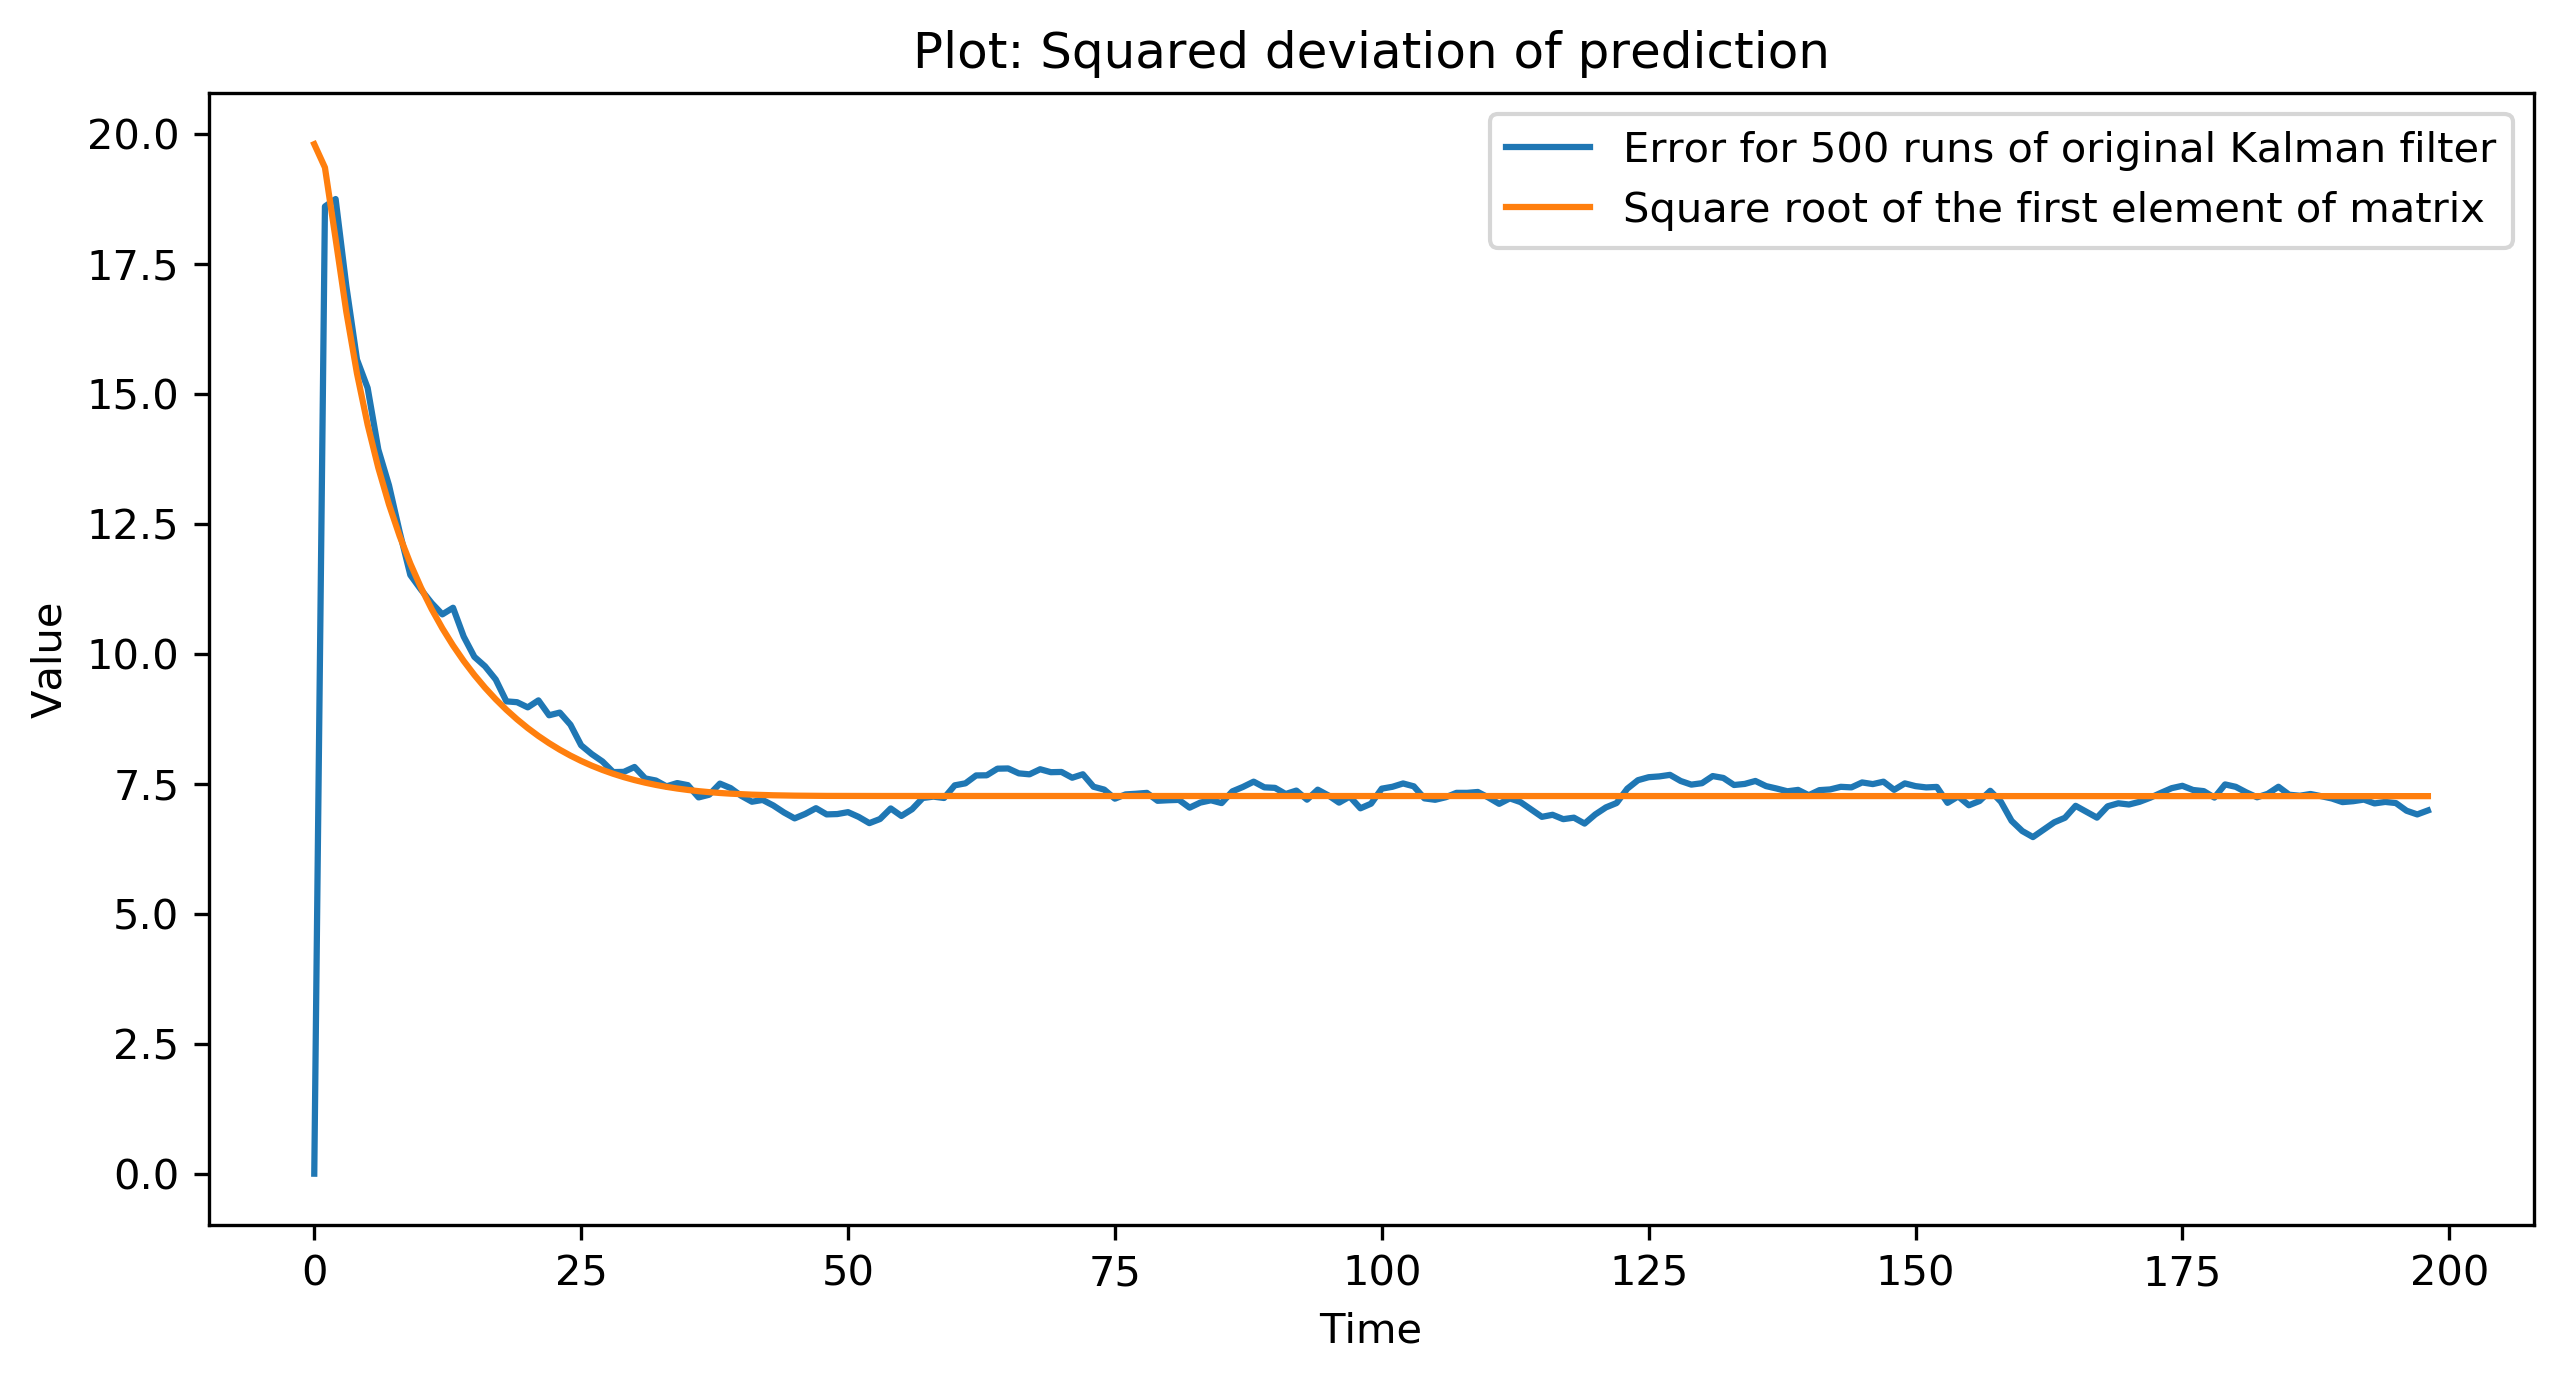

In [20]:
err_k = run(500)
#deleting first row
err_k = np.delete(err_k, 0)
figure(num=None, figsize=(10, 5), dpi=300, facecolor='w', edgecolor='k')
plt.title('Plot: Squared deviation of prediction')
plt.plot(err_k, label='Error for 500 runs of original Kalman filter')
plt.plot(p, label='Square root of the first element of matrix')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [12]:
#Kalman filtering with K = K/5
def kalmandiv5(x):
    P = P00
    X_f = np.zeros([c,2])
    K_f = np.zeros([c,2])
    P_g = np.zeros(c)
    X_f[0] = X0
    for i in range (1,c):
        X_p = F.dot(np.asmatrix(X_f[i-1]).T)
        Pz = np.add(F.dot(P).dot(F.T),Q)
        frst = np.add(H.dot(Pz).dot(H.T),R)
        K = Pz.dot(H.T).dot(np.linalg.inv(frst))
        K[0] /= 5
        pre_scnd = np.subtract(x[i],H.dot(X_p))
        scnd = K.dot(pre_scnd)
        P = np.matmul(np.subtract(I,np.matmul(K,H)),Pz)
        X_f[i] = np.add(X_p,scnd).T
        K_f[i] = K.T
        P_g[i] = np.sqrt(P[0,0])
    #deleting first row
    K_f = np.delete(K_f, 0, 0)
    P_g = np.delete(P_g, 0, 0)
    return X_f.T, K_f.T[0], P_g
f2, k2, p2 = kalmandiv5(Z)

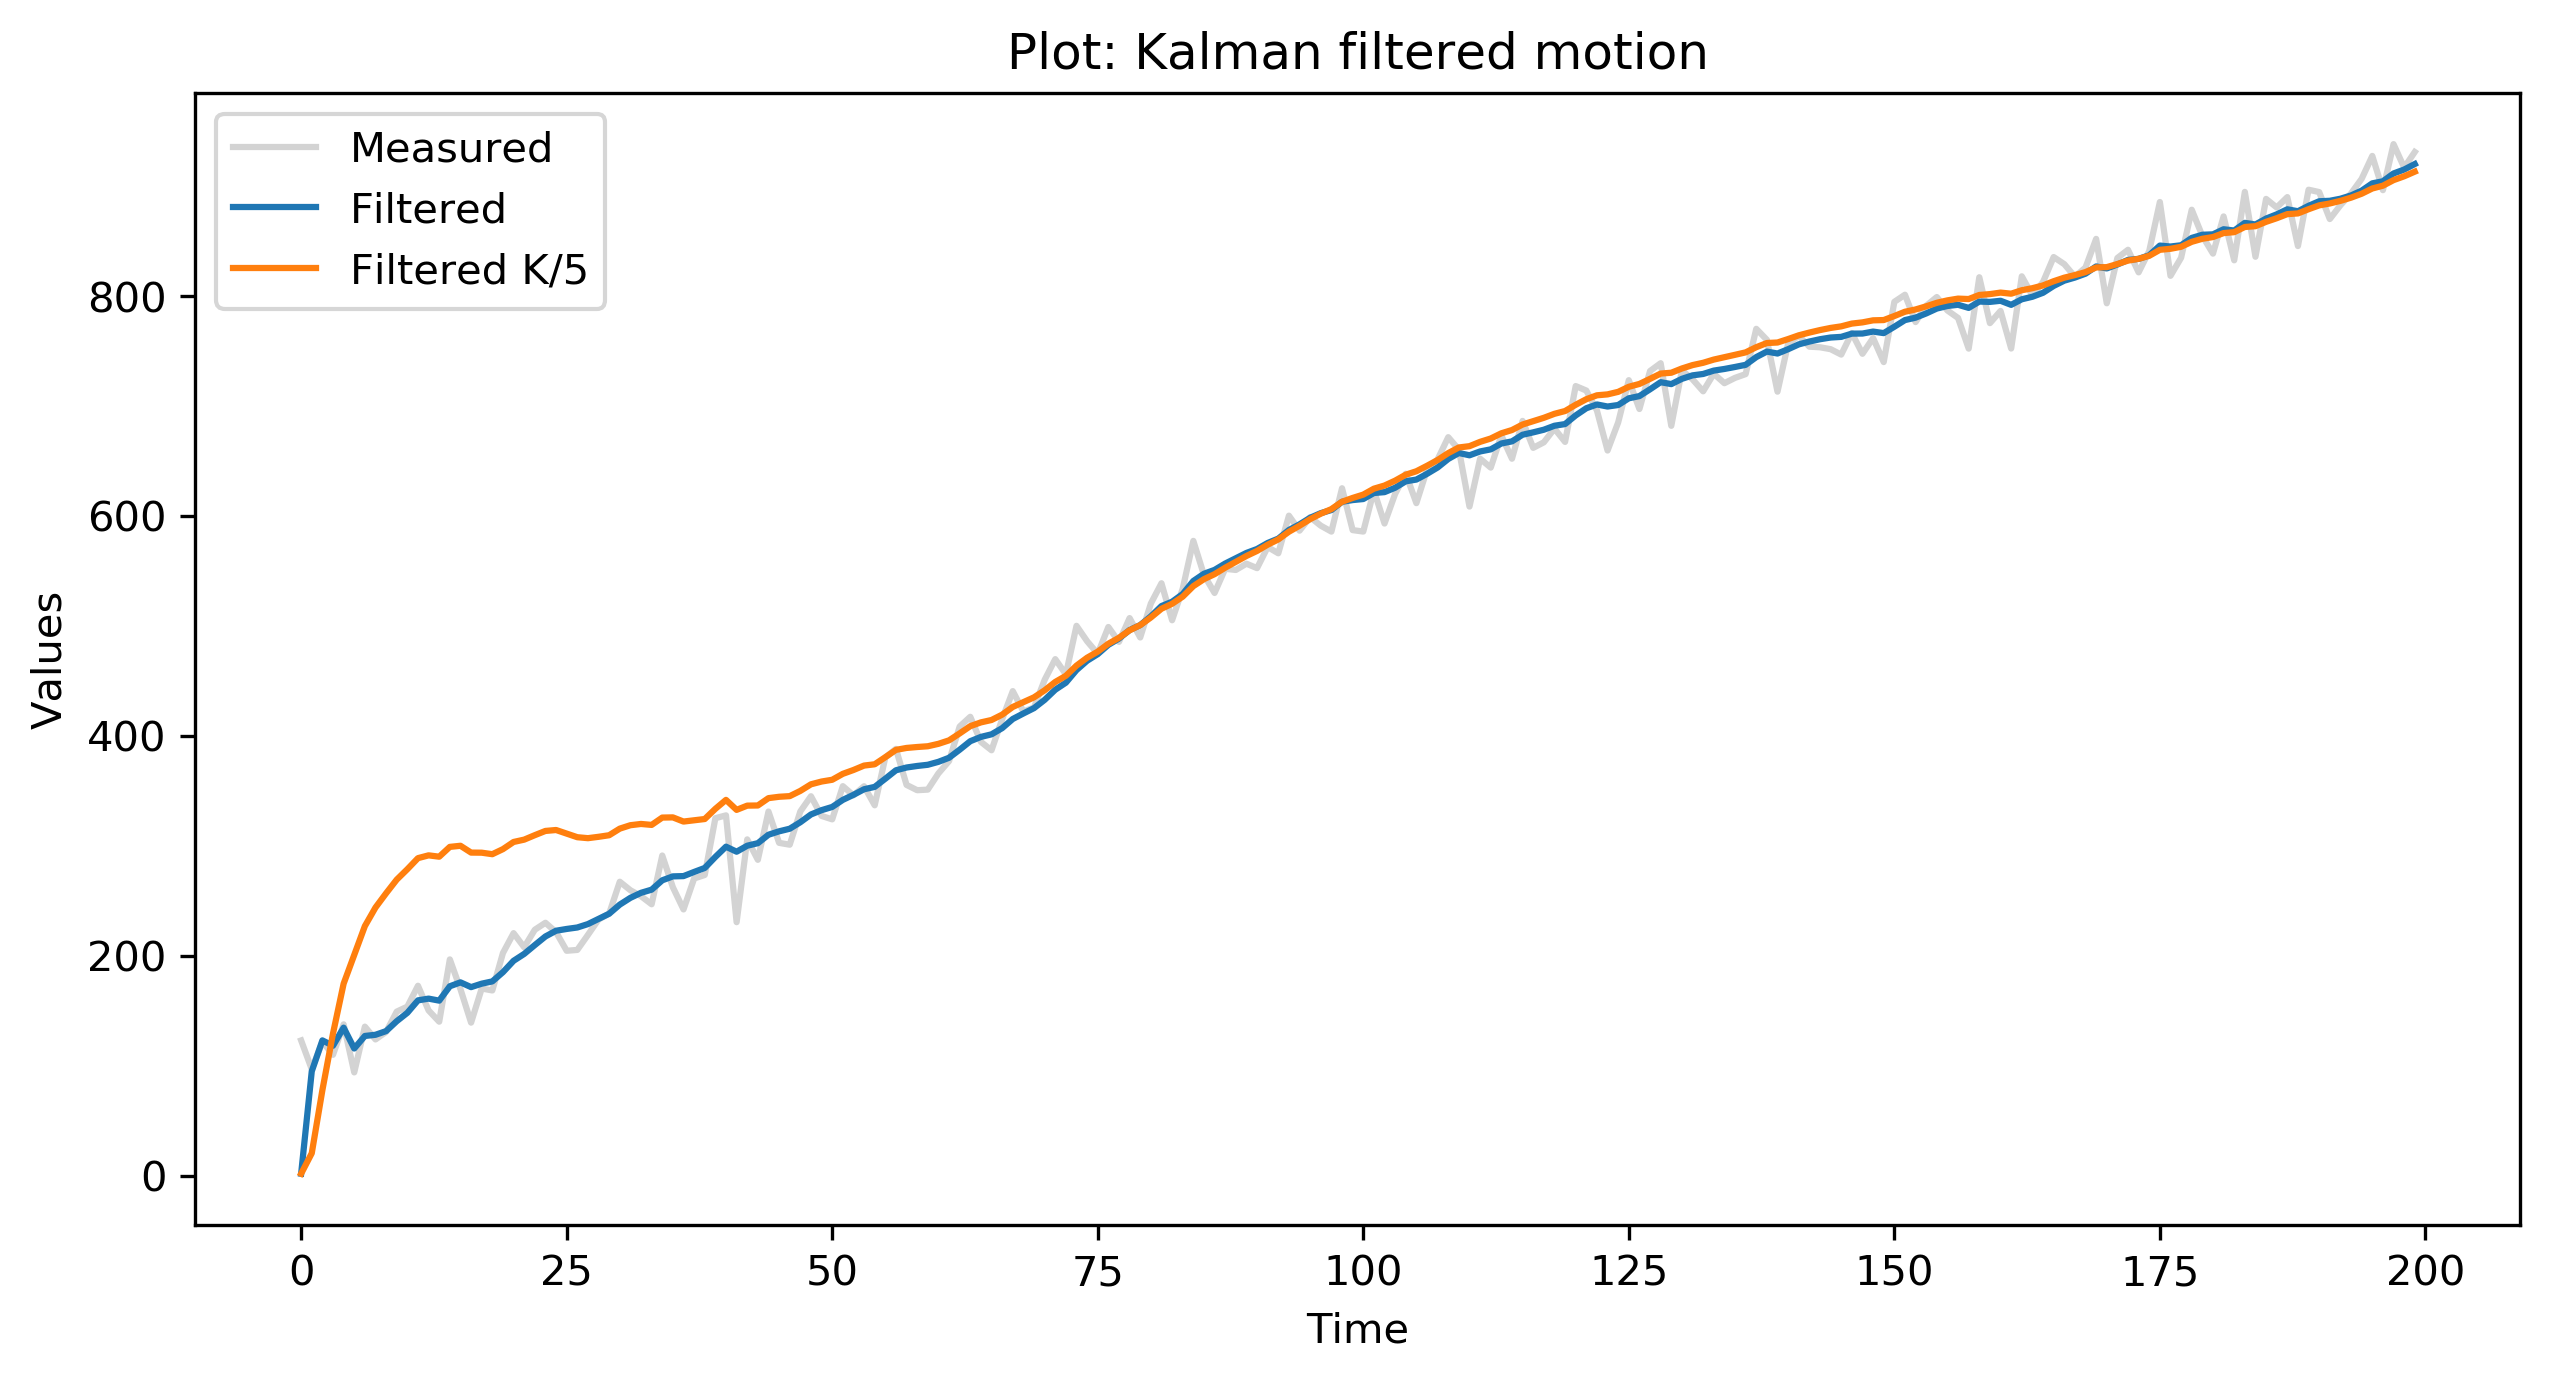

In [13]:
#Plotting the result
figure(num=None, figsize=(10, 5), dpi=300, facecolor='w', edgecolor='k')
plt.title('Plot: Kalman filtered motion')
plt.plot(Z, label='Measured', c='lightgrey')
plt.plot(f[0], label='Filtered')
plt.plot(f2[0], label='Filtered K/5')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

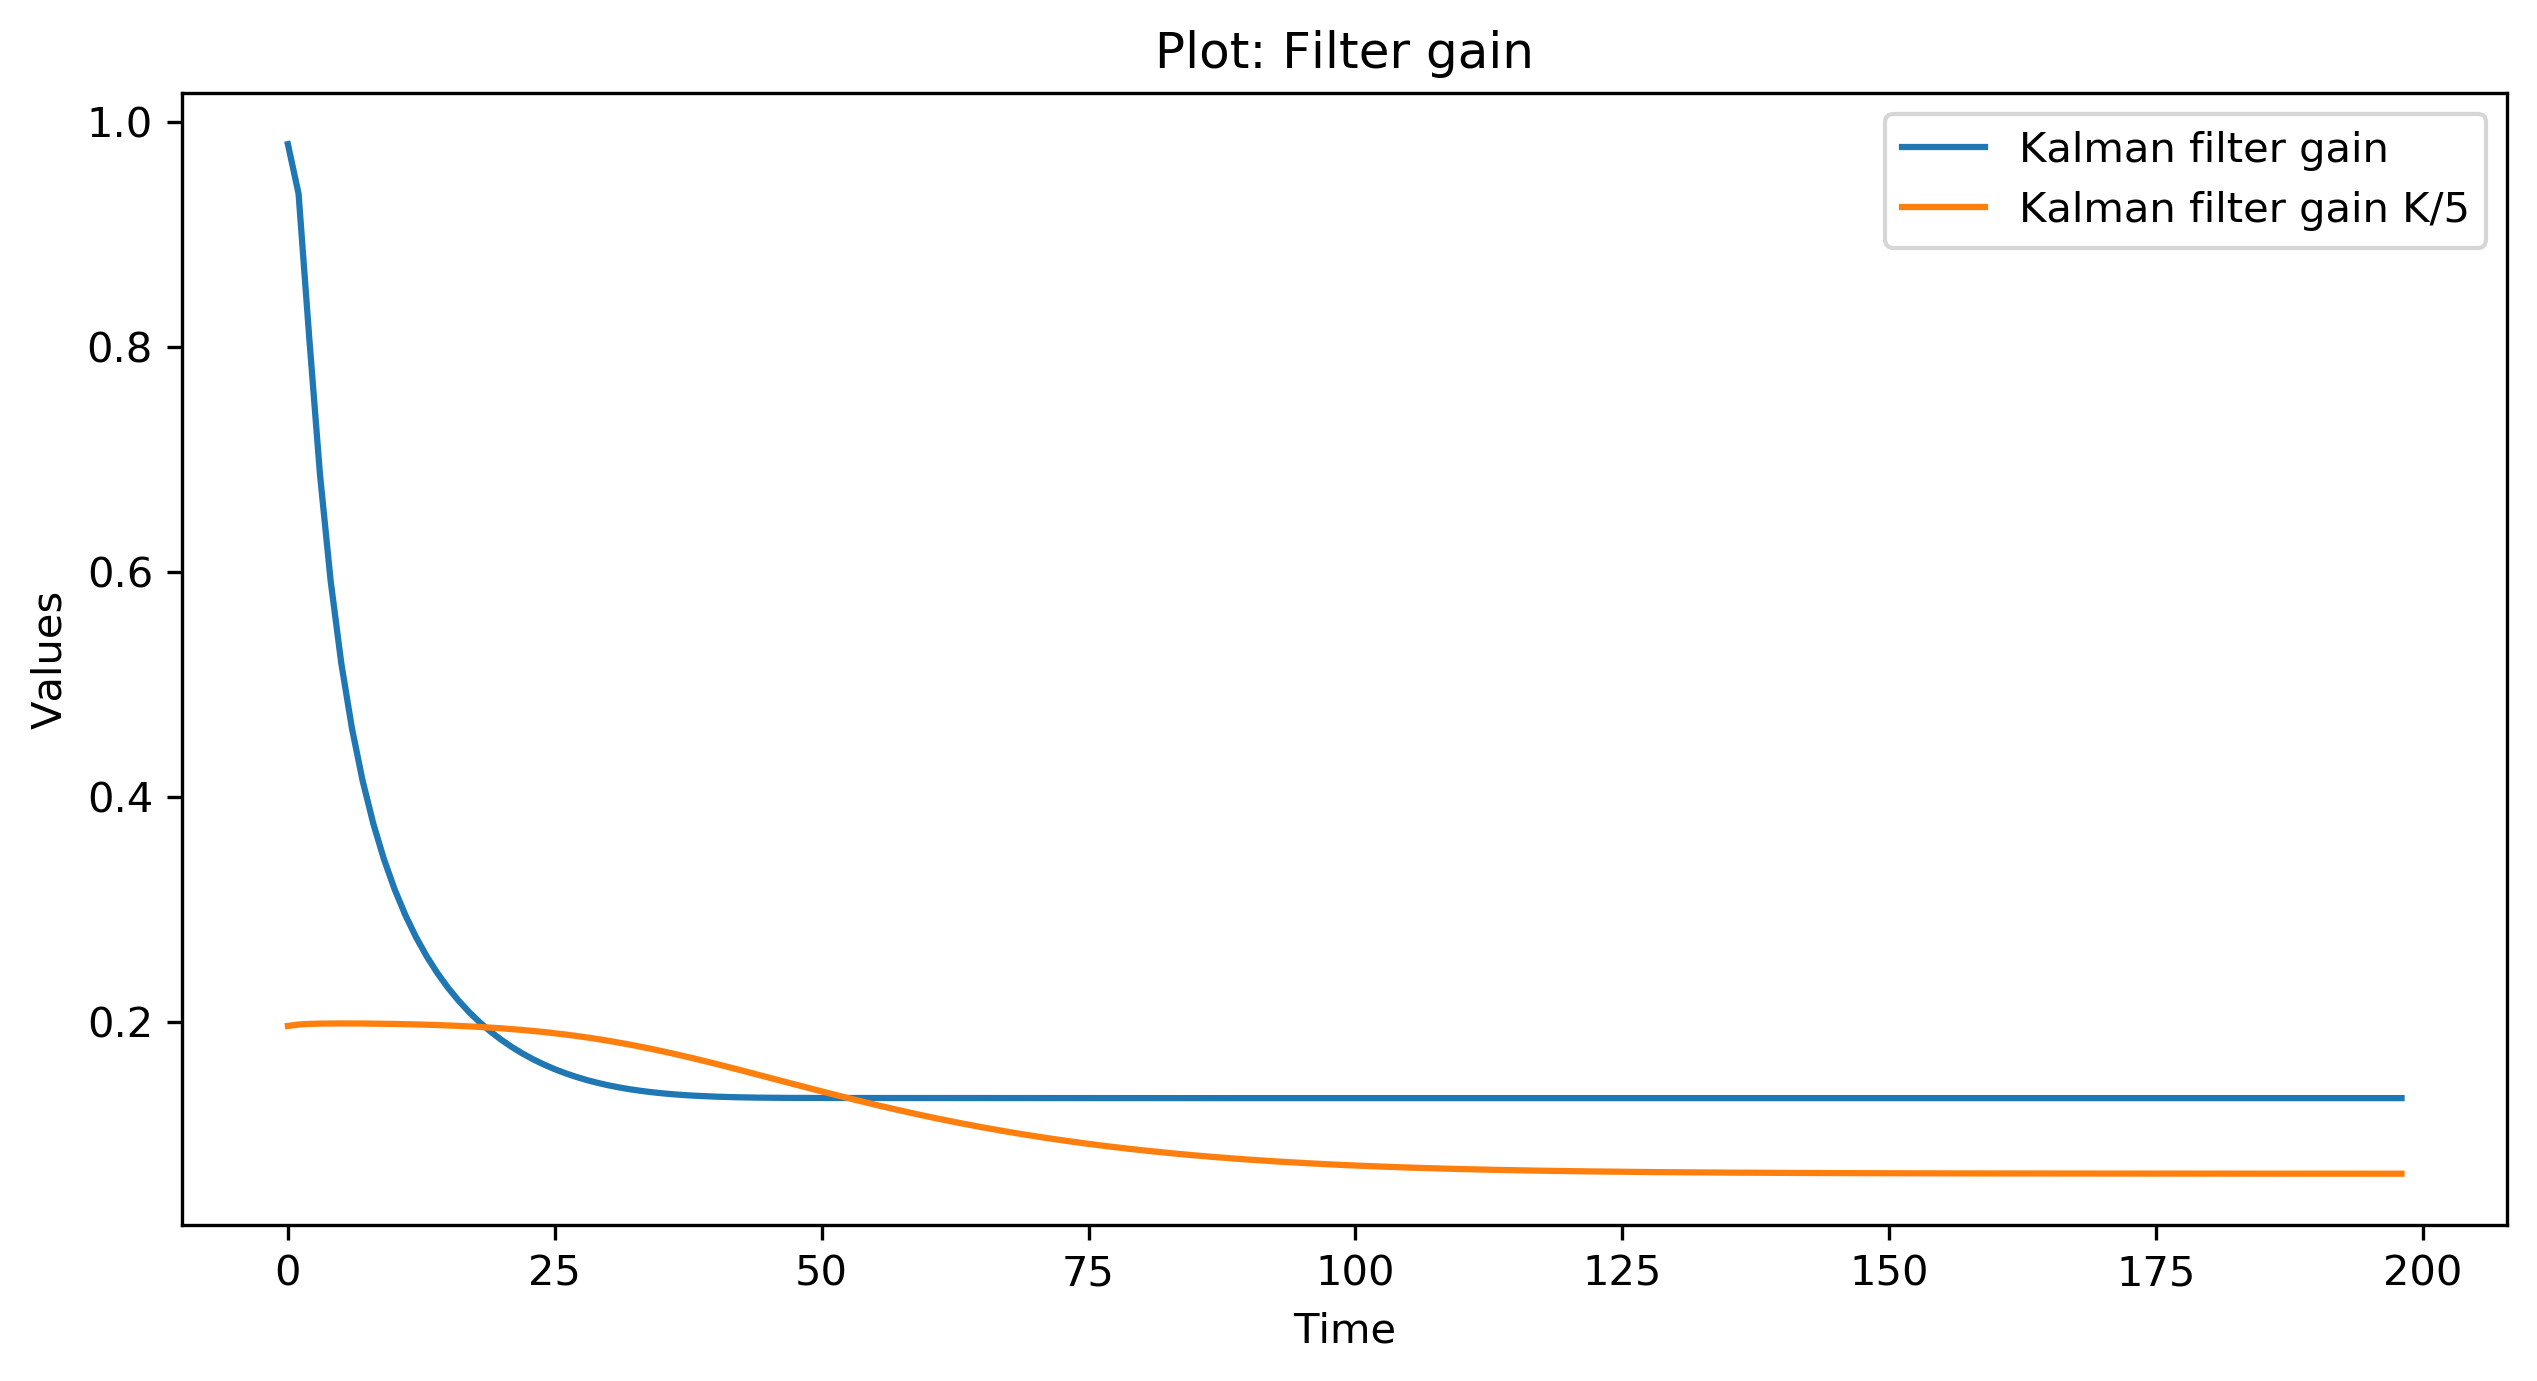

In [14]:
#Plot filter gain K
figure(num=None, figsize=(10, 5), dpi=300, facecolor='w', edgecolor='k')
plt.title('Plot: Filter gain')
plt.plot(k, label='Kalman filter gain')
plt.plot(k2, label='Kalman filter gain K/5')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

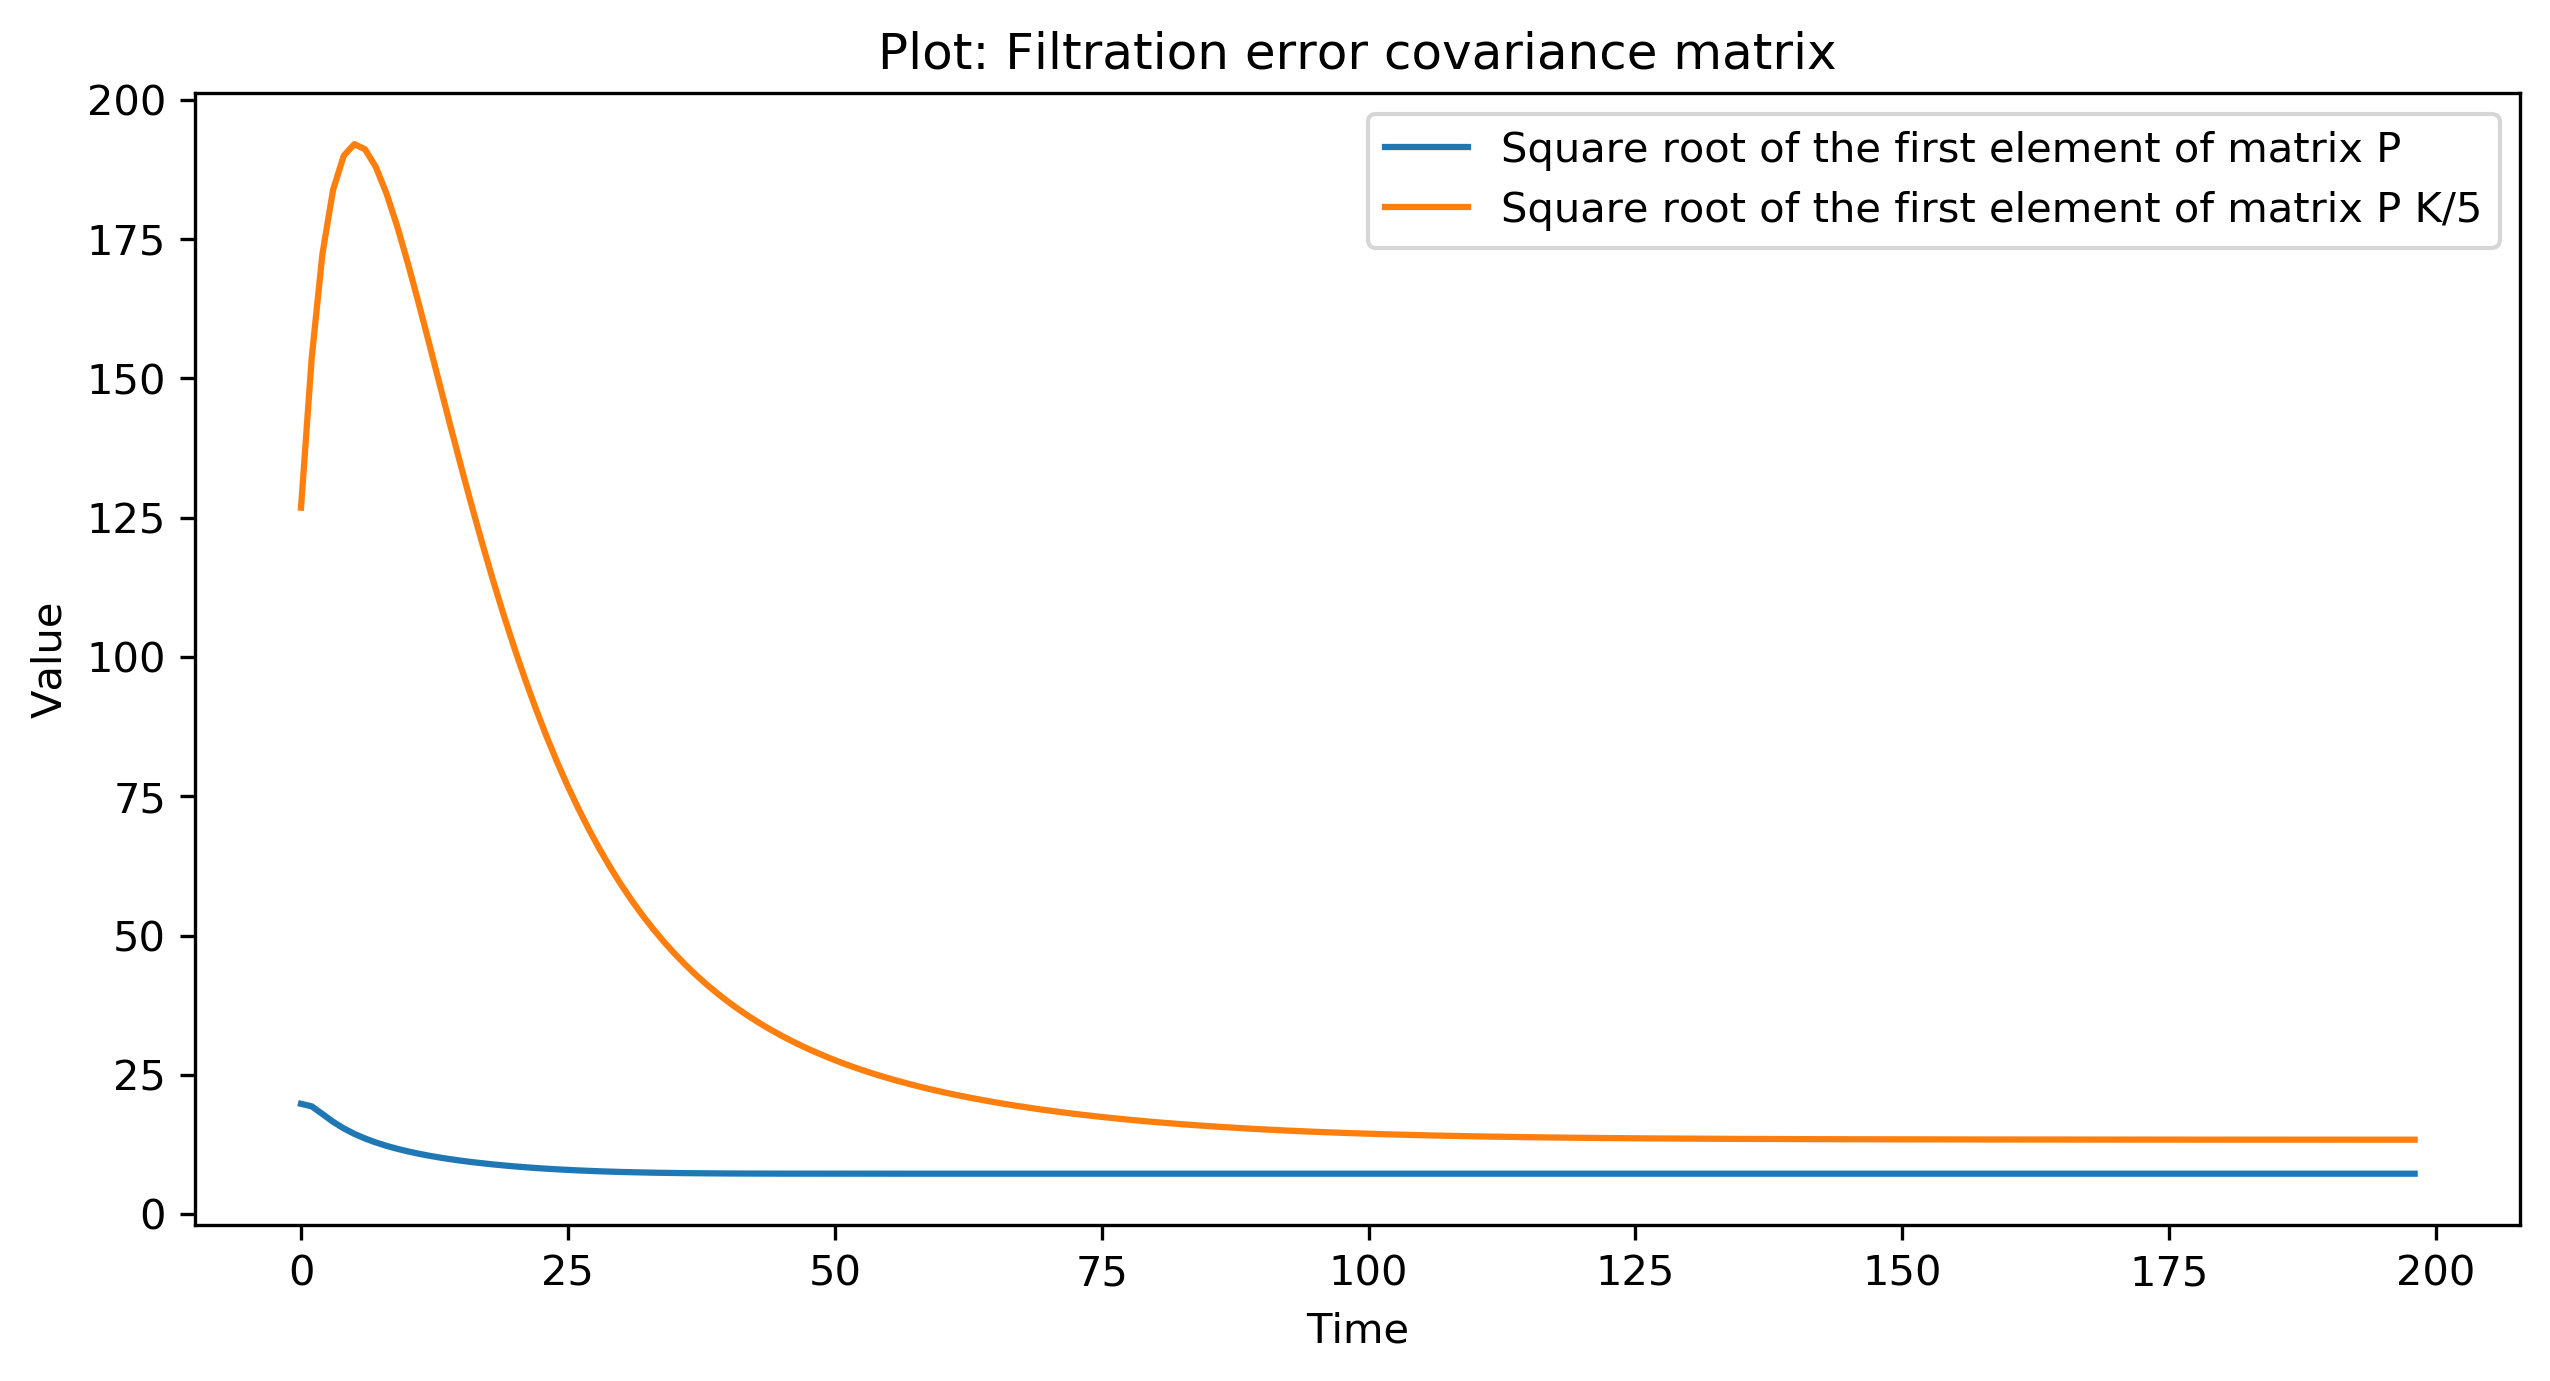

In [15]:
#P
figure(num=None, figsize=(10, 5), dpi=300, facecolor='w', edgecolor='k')
plt.title('Plot: Filtration error covariance matrix')    
plt.plot(p, label='Square root of the first element of matrix P')
plt.plot(p2, label='Square root of the first element of matrix P K/5')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [16]:
def run2(n):
    def gen():
        a = np.random.normal(0,sa,c)
        n = np.random.normal(0,sn,c)
        X1 = np.matrix((5,1))
        F = np.matrix(((1,t),(0,1)))
        G = np.matrix((t**2/2,t)).T
        H = np.matrix((1,0))

        X = np.zeros([c,2])
        X[0] = X1
        for i in range (1,c):
            frst = np.matmul(F,np.asmatrix(X[i-1]).T)
            scnd = G.dot(a[i-1])
            X[i] = np.add(frst,scnd).T
        Z = np.zeros(c)
        for i in range (c):
            Z[i] = H.dot(X[i])+n[i]
        return X.T,Z
        
    def kalman(z_g):
        P = P00
        X_f = np.zeros([c,2])
        X_f[0] = X0
        for i in range (1,c):
            X_p = F.dot(np.asmatrix(X_f[i-1]).T)
            Pz = np.add(F.dot(P).dot(F.T),Q)
            frst = np.add(H.dot(Pz).dot(H.T),R)
            K = Pz.dot(H.T).dot(np.linalg.inv(frst))
            K[0] /= 5
            pre_scnd = np.subtract(z_g[i],H.dot(X_p))
            scnd = K.dot(pre_scnd)
            P = np.matmul(np.subtract(I,np.matmul(K,H)),Pz)
            X_f[i] = np.add(X_p,scnd).T
        return X_f.T

    error = np.zeros(c)
    for i in range (n):
        cur_x,cur_z = gen()
        res = kalman(cur_z)
        s = np.power(np.subtract(cur_x[0],res[0]),2)
        error = np.add(s,error)
    final = np.zeros(c)
    for k in range (2,c):
        final[k] = np.sqrt(error[k]/(n-1))
    return final
err_k2 = run2(500)

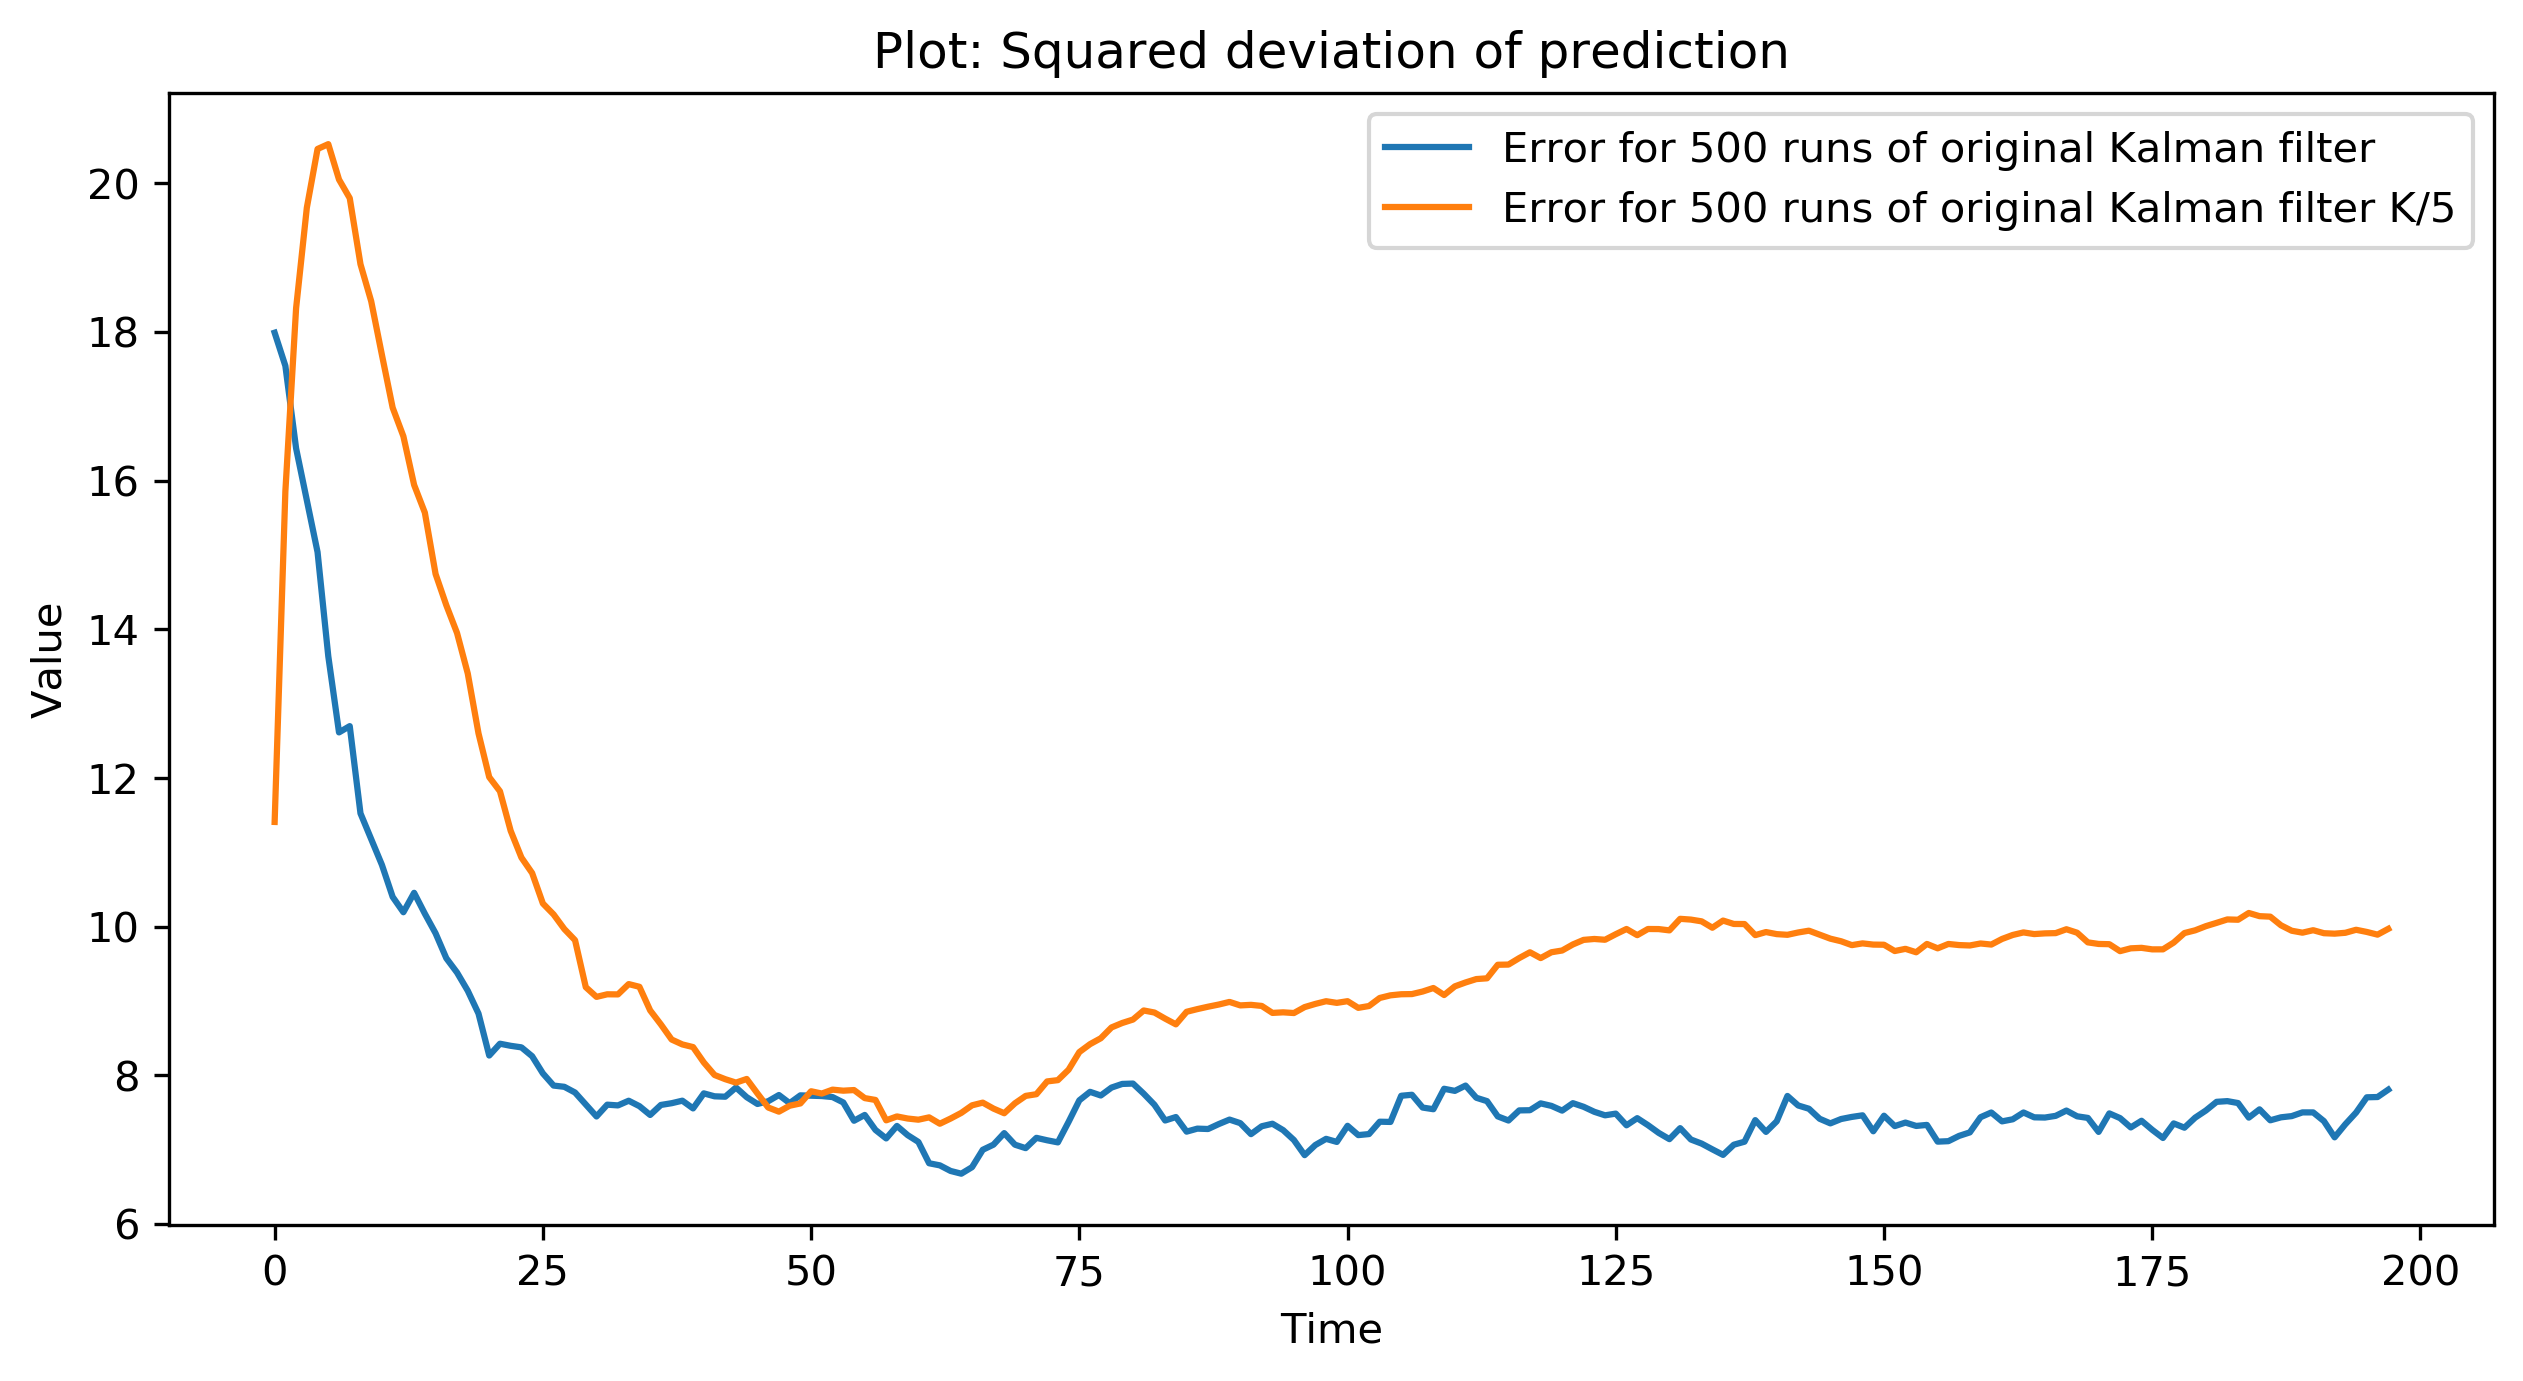

In [19]:
#deleting first row
err_k = np.delete(err_k, 0)
err_k2 = np.delete(err_k2, 0)

figure(num=None, figsize=(10, 5), dpi=300, facecolor='w', edgecolor='k')
plt.title('Plot: Squared deviation of prediction')
plt.plot(err_k, label='Error for 500 runs of original Kalman filter')
plt.plot(err_k2, label='Error for 500 runs of original Kalman filter K/5')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()